In [50]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import autocast, GradScaler
torch.manual_seed(42)

In [51]:
z = torch.rand(size=(100,50))

dirichlet = torch.distributions.Dirichlet(z)
p_set = dirichlet.sample()
N, K = p_set.size()

mu1_tilde = torch.mean(p_set, axis=0)
mu2_tilde = torch.mean(torch.pow(p_set,2), axis=0)

S = 1/K * torch.sum((mu1_tilde-mu2_tilde) / (mu2_tilde-torch.pow(mu1_tilde,2)))

alpha = S/N * torch.sum(p_set, axis=0)

In [52]:
alpha.size()

torch.Size([50])

In [53]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.dense1 = nn.Linear(784, 500)
        self.dense2 = nn.Linear(500, 500)
        self.dense3 = nn.Linear(500, latent_dim)

    def sample(self, alpha_hat):
        u = torch.rand(size=alpha_hat.size(), requires_grad=True).to(device)
        v = torch.pow(u * alpha_hat * torch.exp(torch.lgamma(alpha_hat)),1.0/alpha_hat)
        z = v / torch.sum(v)
        return z

    def forward(self, x):
        alpha_hat = x.view(-1, 28*28)
        alpha_hat = F.relu(self.dense1(alpha_hat))
        alpha_hat = F.relu(self.dense2(alpha_hat))
        alpha_hat = F.softplus(self.dense3(alpha_hat))
        z = self.sample(alpha_hat)
        return z, alpha_hat

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, 500)
        self.dense2 = nn.Linear(500, 28*28)

    def forward(self, x):
        x_hat = F.relu(self.dense1(x))
        return self.dense2(x_hat)

In [54]:
class DirVAE(nn.Module):
    def __init__(self, latent_dim):
        super(DirVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        z, alpha_hat = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, alpha_hat, z

In [55]:
def ELBO(x_hat, x, alpha_hat, alpha):
    
    likelihood = F.binary_cross_entropy_with_logits(x_hat, x.view(-1, 28*28), reduction='sum')
    
    lgamma_alpha = torch.lgamma(alpha).to(device)
    lgamma_alpha_hat = torch.lgamma(alpha_hat).to(device)
    digamma_alpha_hat = torch.digamma(alpha_hat).to(device)
    
    kld = torch.sum(lgamma_alpha - lgamma_alpha_hat + (alpha_hat - alpha) * digamma_alpha_hat)
    
#     if torch.isnan(likelihood):
#         print('LIKELIHOOD IS NAN')
        
#     if torch.isnan(kld):
#         print('KLD IS NAN') 

    return likelihood + kld

In [56]:
def update_alpha_mme(z):
    dirichlet = torch.distributions.Dirichlet(z)
    p_set = dirichlet.sample()
    N, K = p_set.size()

    mu1_tilde = torch.mean(p_set, axis=0)
    mu2_tilde = torch.mean(torch.pow(p_set,2), axis=0)

    S = 1/K * torch.sum((mu1_tilde-mu2_tilde) / (mu2_tilde-torch.pow(mu1_tilde,2)))

    alpha = S/N * torch.sum(p_set, axis=0)
    
    return alpha
    

loss at end of epoch 0: 19923.7578125
test loss at end of epoch 0: 20526.080078125
ORIGINAL


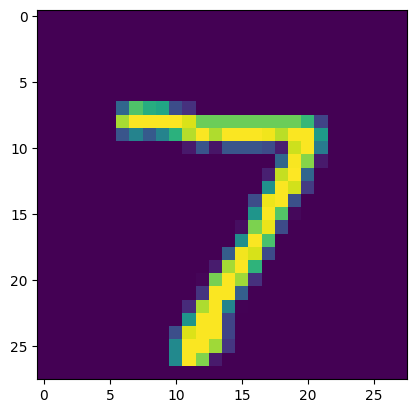

RECONSTRUCTED


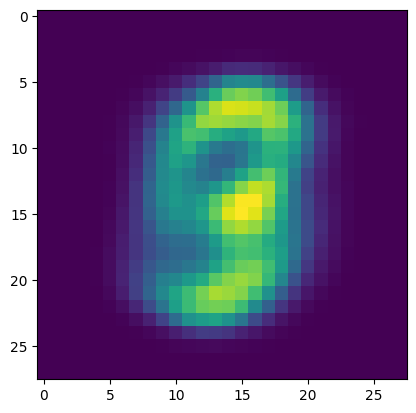

loss at end of epoch 1: 20032.501953125
test loss at end of epoch 1: 20732.470703125
RECONSTRUCTED


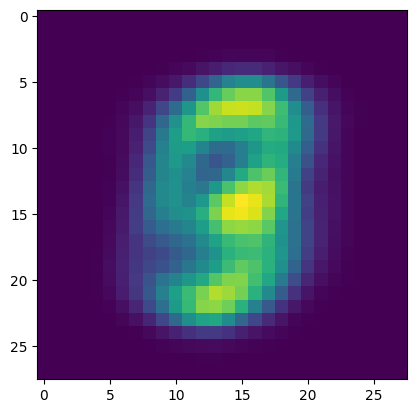

loss at end of epoch 2: 21285.693359375
test loss at end of epoch 2: 20465.73046875
RECONSTRUCTED


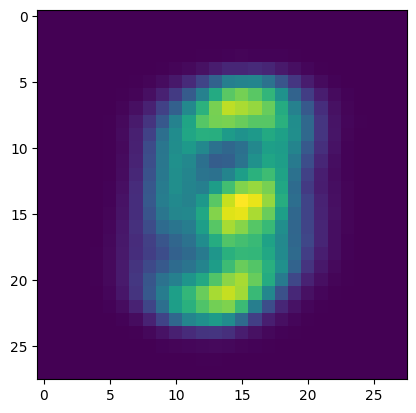

loss at end of epoch 3: 21006.34765625
test loss at end of epoch 3: 20800.478515625
RECONSTRUCTED


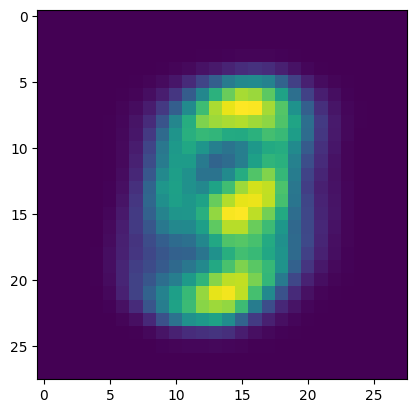

loss at end of epoch 4: 20840.947265625
test loss at end of epoch 4: 20267.568359375
RECONSTRUCTED


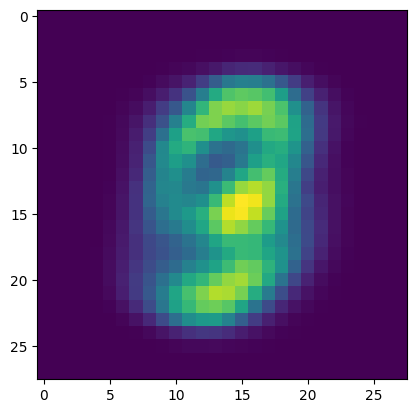

loss at end of epoch 5: 20785.767578125
test loss at end of epoch 5: 20626.173828125
RECONSTRUCTED


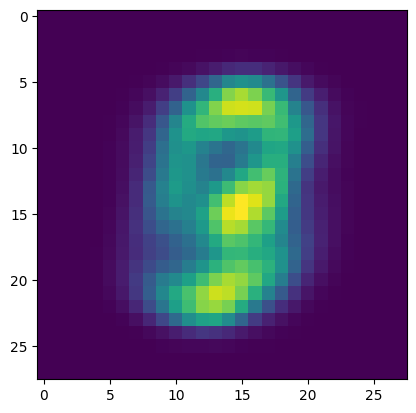

loss at end of epoch 6: 20033.8828125
test loss at end of epoch 6: 20676.01953125
RECONSTRUCTED


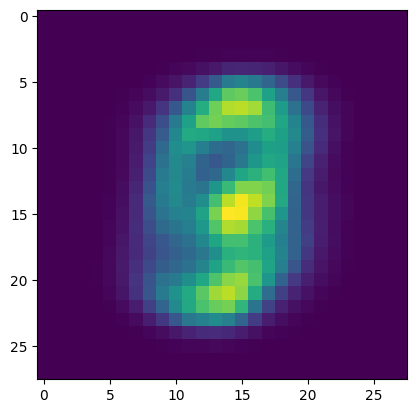

loss at end of epoch 7: 20736.451171875
test loss at end of epoch 7: 20203.349609375
RECONSTRUCTED


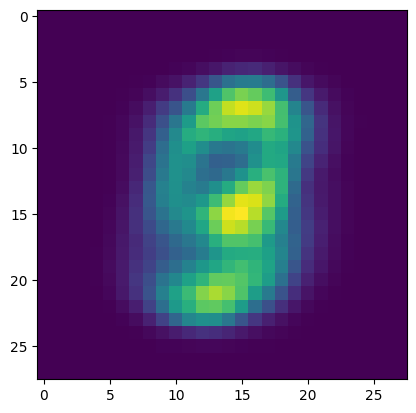

loss at end of epoch 8: 20939.5625
test loss at end of epoch 8: 20081.55078125
RECONSTRUCTED


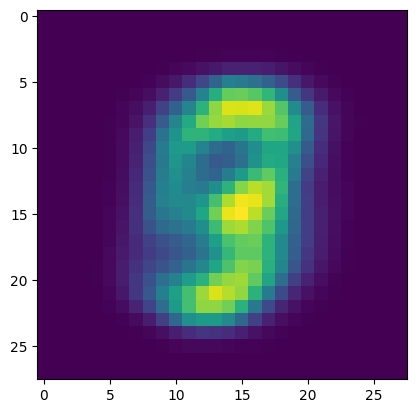

loss at end of epoch 9: 20741.80859375
test loss at end of epoch 9: 20279.03515625
RECONSTRUCTED


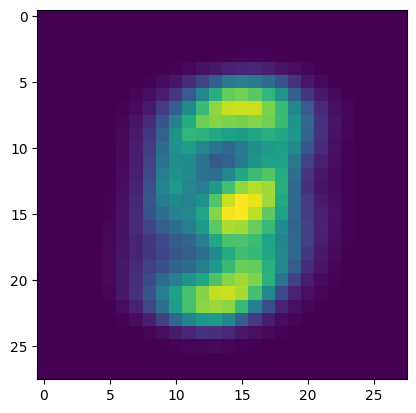

loss at end of epoch 10: 21594.8671875
test loss at end of epoch 10: 19311.828125
RECONSTRUCTED


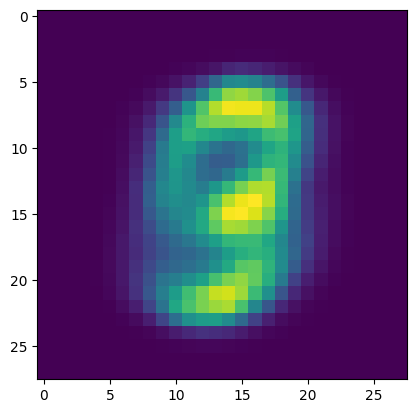

loss at end of epoch 11: 20338.86328125
test loss at end of epoch 11: 20739.49609375
RECONSTRUCTED


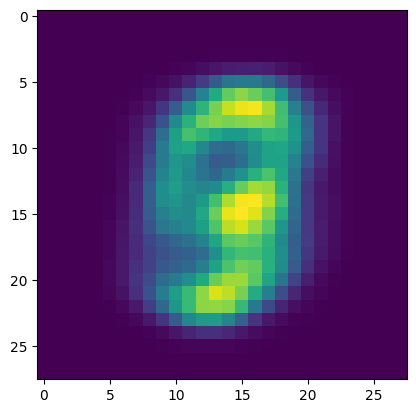

loss at end of epoch 12: 20398.609375
test loss at end of epoch 12: 20618.25390625
RECONSTRUCTED


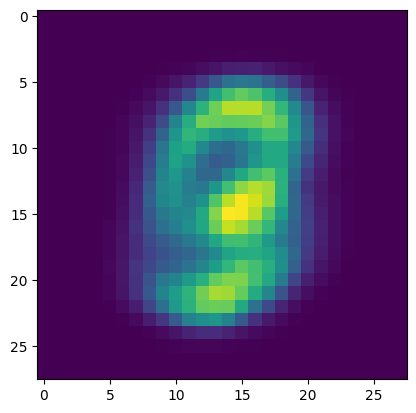

loss at end of epoch 13: 19815.865234375
test loss at end of epoch 13: 21619.412109375
RECONSTRUCTED


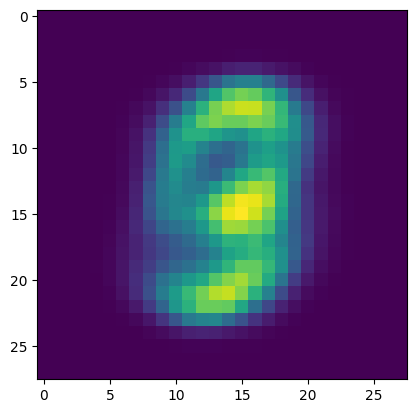

loss at end of epoch 14: 20943.63671875
test loss at end of epoch 14: 20908.732421875
RECONSTRUCTED


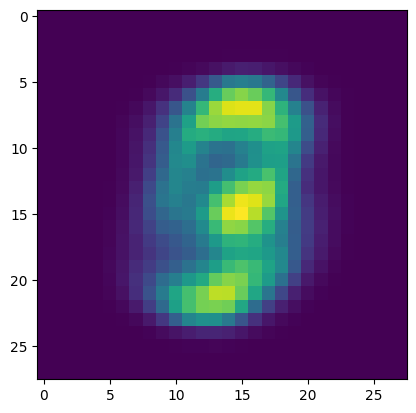

loss at end of epoch 15: 20398.53515625
test loss at end of epoch 15: 21264.380859375
RECONSTRUCTED


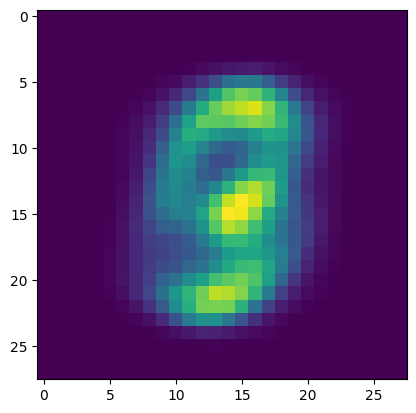

loss at end of epoch 16: 20499.12890625
test loss at end of epoch 16: 20603.115234375
RECONSTRUCTED


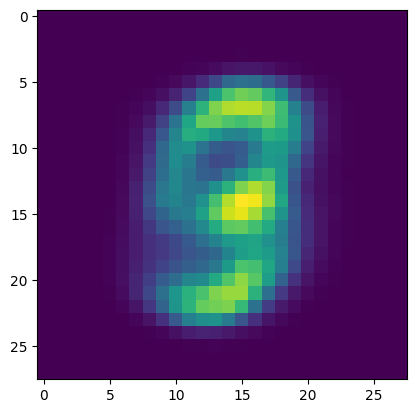

loss at end of epoch 17: 20996.904296875
test loss at end of epoch 17: 20845.1875
RECONSTRUCTED


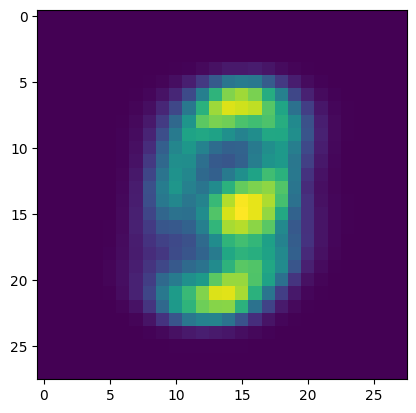

loss at end of epoch 18: 20949.416015625
test loss at end of epoch 18: 21035.451171875
RECONSTRUCTED


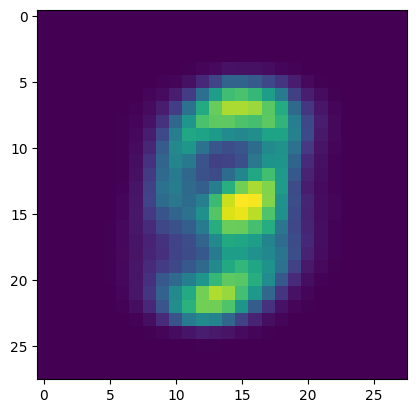

loss at end of epoch 19: 20565.732421875
test loss at end of epoch 19: 19875.861328125
RECONSTRUCTED


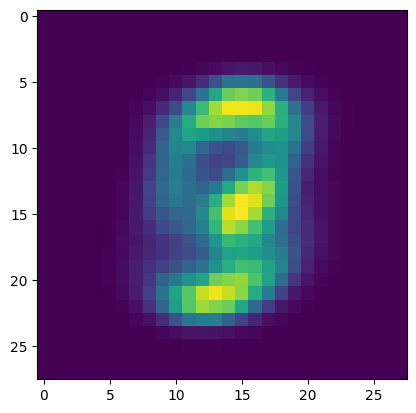

loss at end of epoch 20: 19705.521484375
test loss at end of epoch 20: 20686.3828125
RECONSTRUCTED


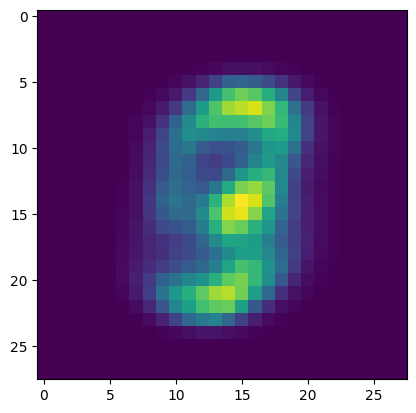

loss at end of epoch 21: 21094.0078125
test loss at end of epoch 21: 20402.216796875
RECONSTRUCTED


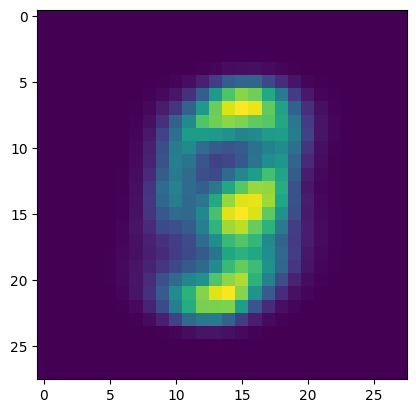

loss at end of epoch 22: 20390.39453125
test loss at end of epoch 22: 20113.072265625
RECONSTRUCTED


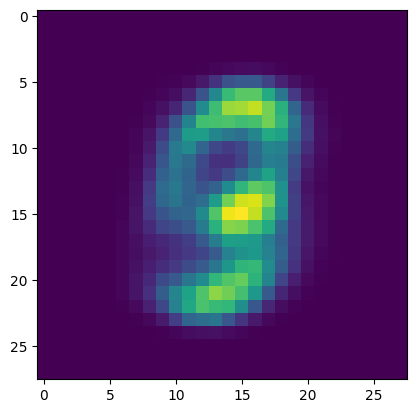

loss at end of epoch 23: 20834.142578125
test loss at end of epoch 23: 19391.58984375
RECONSTRUCTED


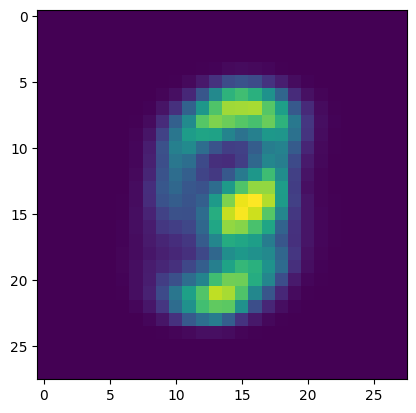

loss at end of epoch 24: 20384.244140625
test loss at end of epoch 24: 21389.154296875
RECONSTRUCTED


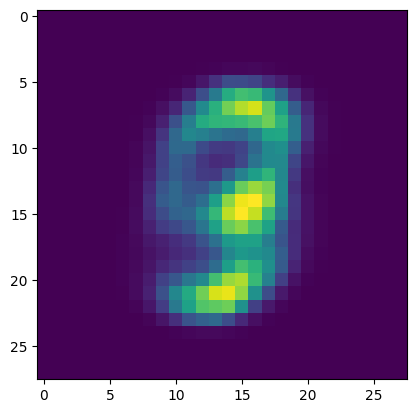

loss at end of epoch 25: 20446.587890625
test loss at end of epoch 25: 20650.4921875
RECONSTRUCTED


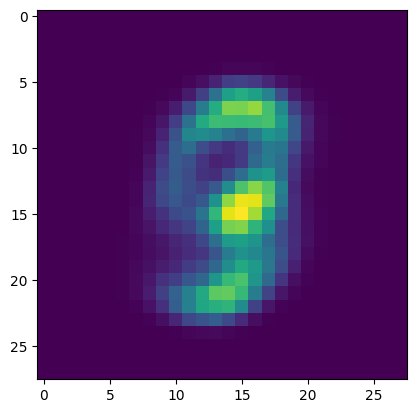

loss at end of epoch 26: 21604.712890625
test loss at end of epoch 26: 20686.544921875
RECONSTRUCTED


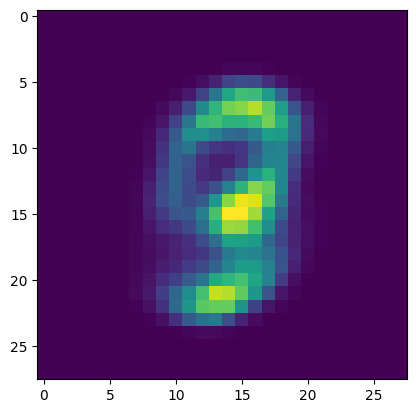

loss at end of epoch 27: 20537.25390625
test loss at end of epoch 27: 20635.49609375
RECONSTRUCTED


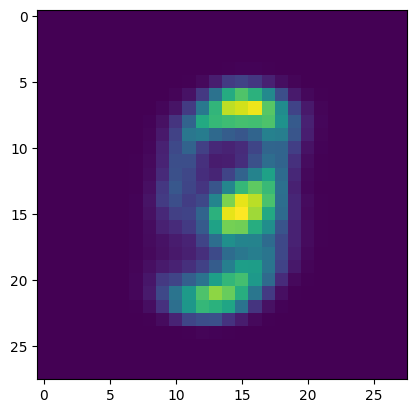

loss at end of epoch 28: 20528.4921875
test loss at end of epoch 28: 20502.1953125
RECONSTRUCTED


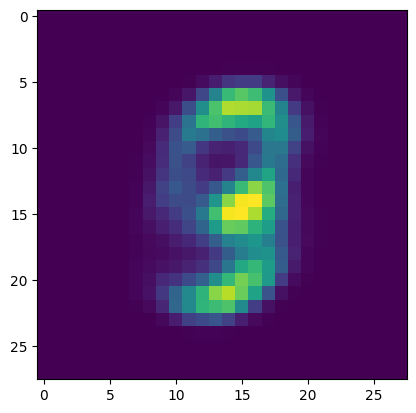

loss at end of epoch 29: 20910.603515625
test loss at end of epoch 29: 19904.724609375
RECONSTRUCTED


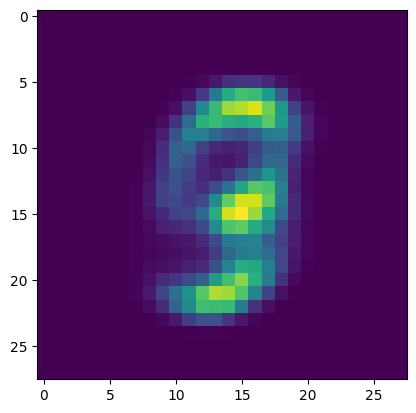

loss at end of epoch 30: 20591.1953125
test loss at end of epoch 30: 21418.216796875
RECONSTRUCTED


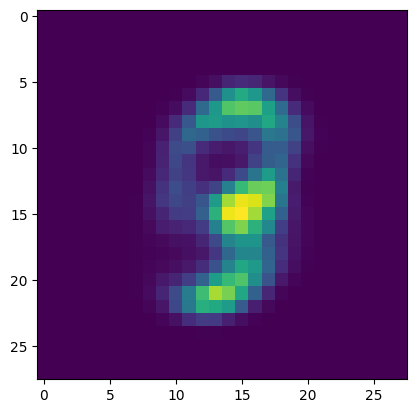

loss at end of epoch 31: 20749.13671875
test loss at end of epoch 31: 21119.466796875
RECONSTRUCTED


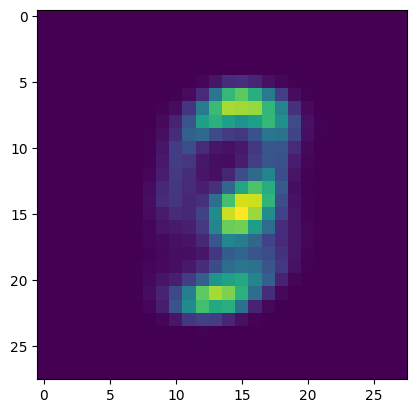

loss at end of epoch 32: 21140.265625
test loss at end of epoch 32: 20127.1171875
RECONSTRUCTED


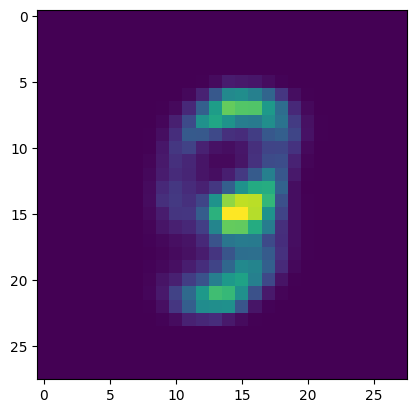

loss at end of epoch 33: 20528.591796875
test loss at end of epoch 33: 21389.880859375
RECONSTRUCTED


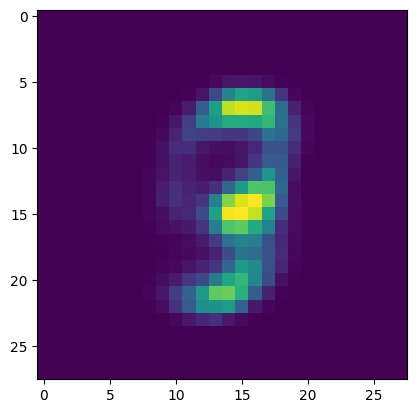

loss at end of epoch 34: 20675.974609375
test loss at end of epoch 34: 20345.037109375
RECONSTRUCTED


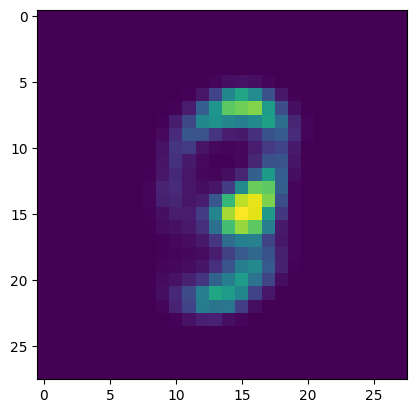

loss at end of epoch 35: 20332.212890625
test loss at end of epoch 35: 21129.240234375
RECONSTRUCTED


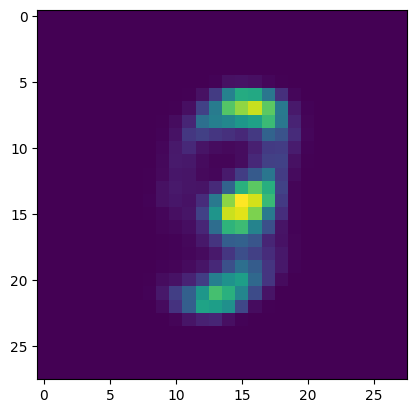

loss at end of epoch 36: 19514.2890625
test loss at end of epoch 36: 20202.35546875
RECONSTRUCTED


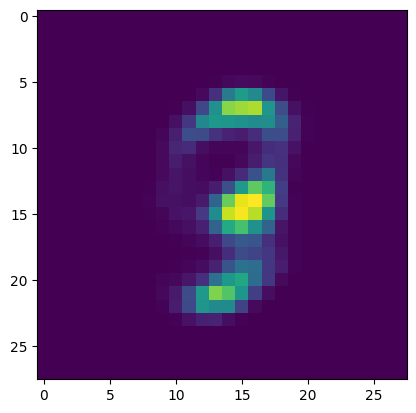

loss at end of epoch 37: 20294.177734375
test loss at end of epoch 37: 20669.7265625
RECONSTRUCTED


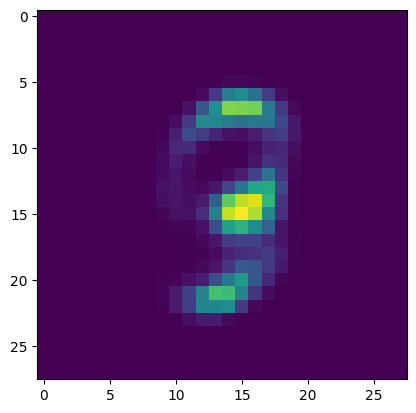

loss at end of epoch 38: 20539.947265625
test loss at end of epoch 38: 20616.7890625
RECONSTRUCTED


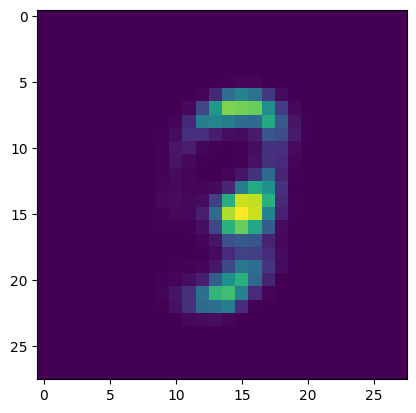

loss at end of epoch 39: 21079.14453125
test loss at end of epoch 39: 20740.134765625
RECONSTRUCTED


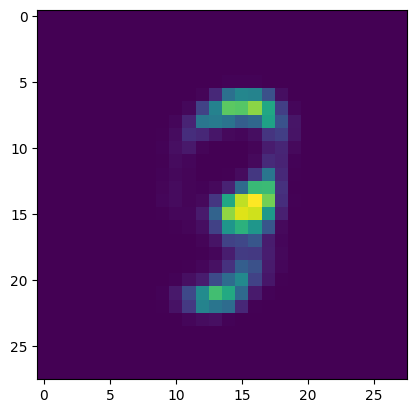

loss at end of epoch 40: 20319.451171875
test loss at end of epoch 40: 20220.455078125
RECONSTRUCTED


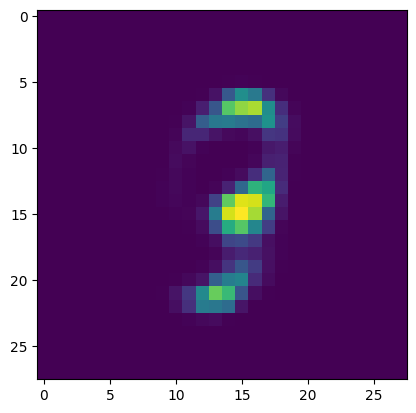

loss at end of epoch 41: 20273.39453125
test loss at end of epoch 41: 20302.650390625
RECONSTRUCTED


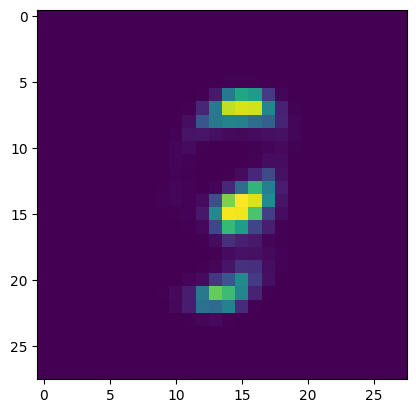

loss at end of epoch 42: 20373.826171875
test loss at end of epoch 42: 20411.408203125
RECONSTRUCTED


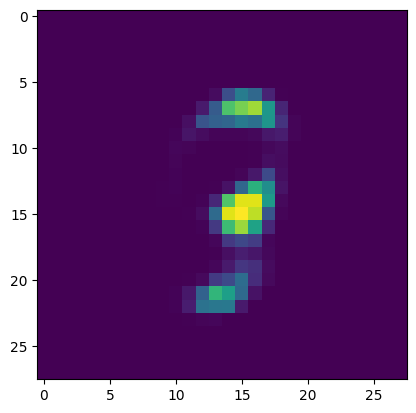

loss at end of epoch 43: 21468.333984375
test loss at end of epoch 43: 20447.03125
RECONSTRUCTED


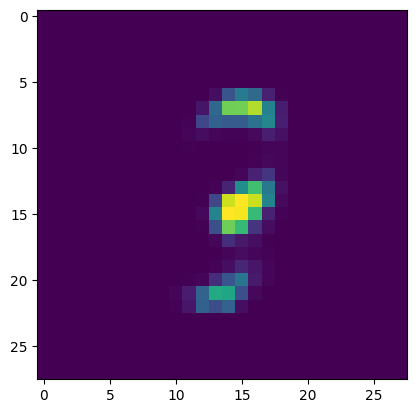

loss at end of epoch 44: 20300.9453125
test loss at end of epoch 44: 21097.73828125
RECONSTRUCTED


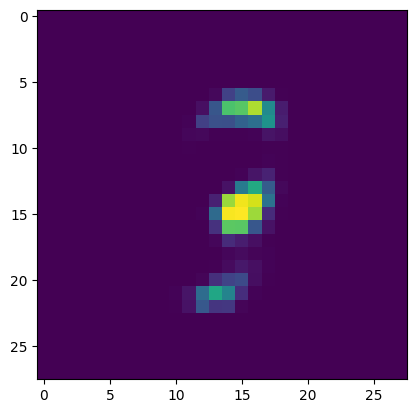

loss at end of epoch 45: 20123.7890625
test loss at end of epoch 45: 20357.23046875
RECONSTRUCTED


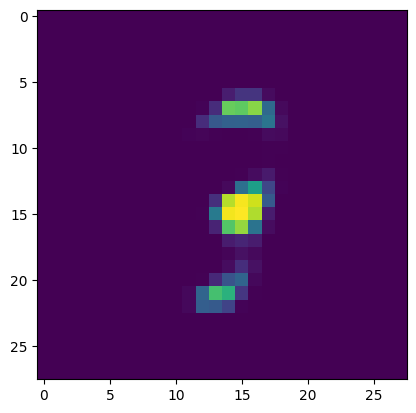

loss at end of epoch 46: 21357.712890625
test loss at end of epoch 46: 20467.609375
RECONSTRUCTED


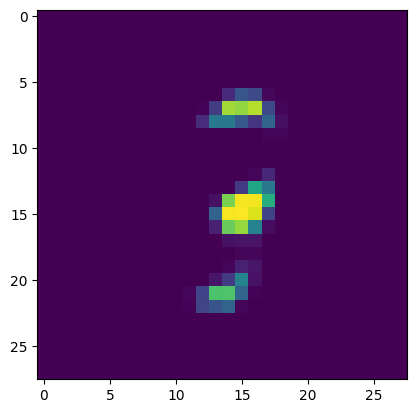

loss at end of epoch 47: 20676.453125
test loss at end of epoch 47: 20909.552734375
RECONSTRUCTED


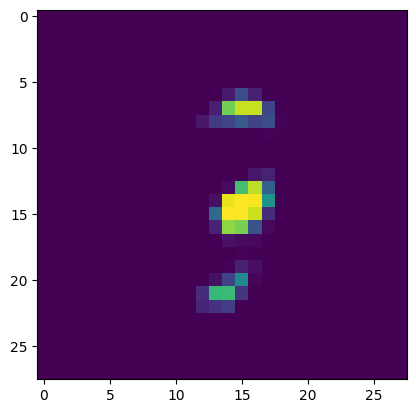

loss at end of epoch 48: 20555.30078125
test loss at end of epoch 48: 20379.091796875
RECONSTRUCTED


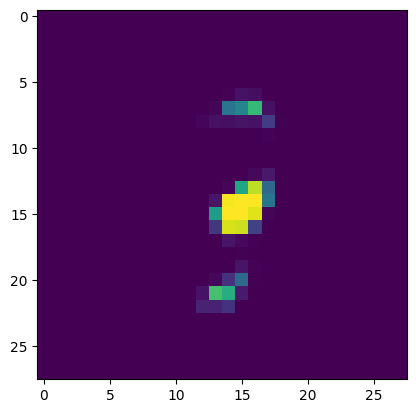

loss at end of epoch 49: 20123.58984375
test loss at end of epoch 49: 20308.89453125
RECONSTRUCTED


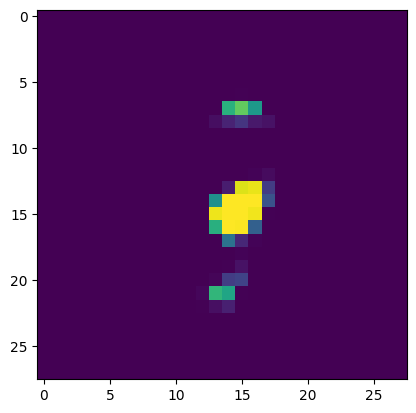

loss at end of epoch 50: 20652.43359375
test loss at end of epoch 50: 20070.484375
RECONSTRUCTED


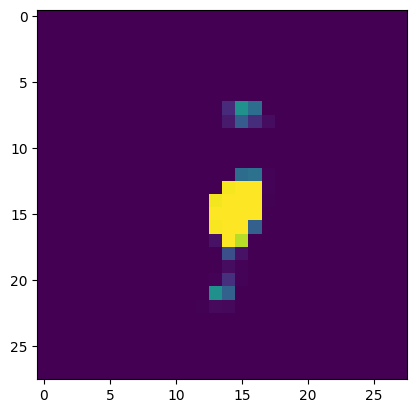

alpha: tensor([0.4112, 0.6362, 0.1863, 0.1863, 0.1863, 0.8611, 0.1863, 0.4112, 0.4075,
        0.7771, 0.4112, 0.4112, 0.1863, 0.3820, 0.4112, 0.1863, 0.4405, 0.4112,
        0.4112, 0.1863, 0.4112, 1.0860, 0.1863, 0.4112, 0.8611, 0.1863, 0.6362,
        0.4112, 0.1863, 0.1864, 0.6362, 0.4112, 0.6362, 0.4112, 0.6362, 0.4112,
        0.6362, 0.8610, 0.4112, 0.4112, 0.1863, 0.1863, 0.4112, 0.4112, 1.0860,
        0.4112, 0.6362, 0.4112, 0.4112, 0.6306], device='cuda:0')
loss at end of epoch 51: 19884.45703125
test loss at end of epoch 51: 19835.611328125
RECONSTRUCTED


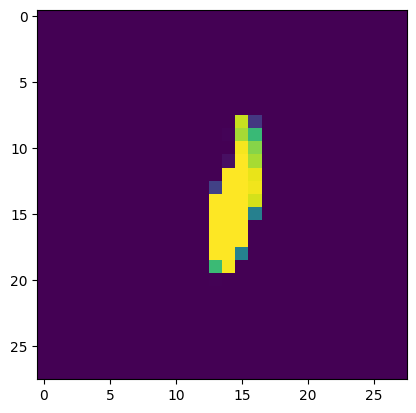

loss at end of epoch 52: 20136.4765625
test loss at end of epoch 52: 19476.361328125
RECONSTRUCTED


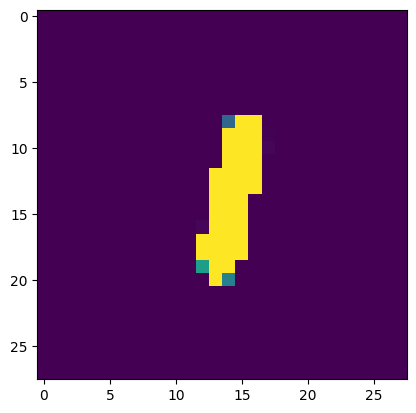

loss at end of epoch 53: 19263.1171875
test loss at end of epoch 53: 19721.671875
RECONSTRUCTED


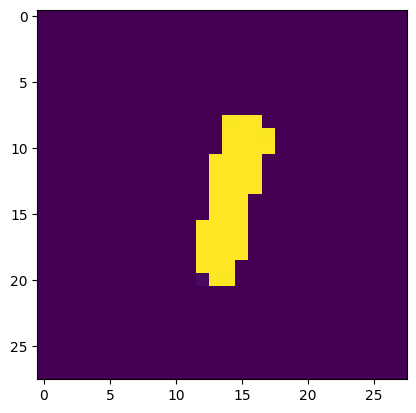

loss at end of epoch 54: 19674.25
test loss at end of epoch 54: 19525.572265625
RECONSTRUCTED


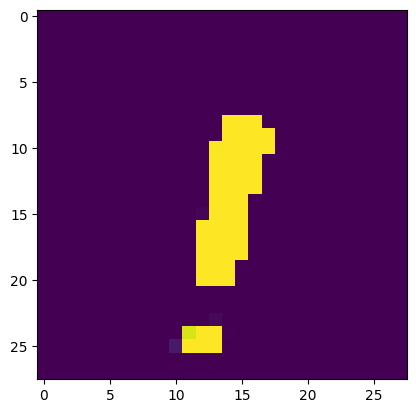

loss at end of epoch 55: 20629.404296875
test loss at end of epoch 55: 19823.591796875
RECONSTRUCTED


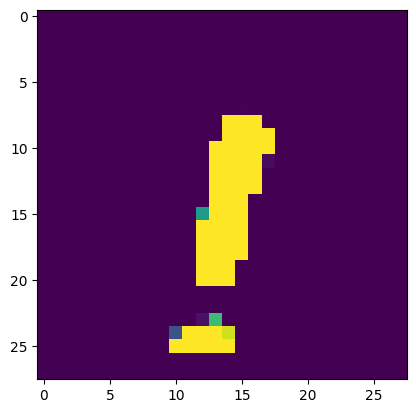

loss at end of epoch 56: 19979.63671875
test loss at end of epoch 56: 19511.09765625
RECONSTRUCTED


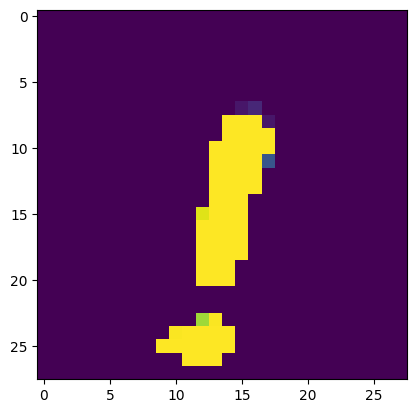

loss at end of epoch 57: 18495.166015625
test loss at end of epoch 57: 19236.8515625
RECONSTRUCTED


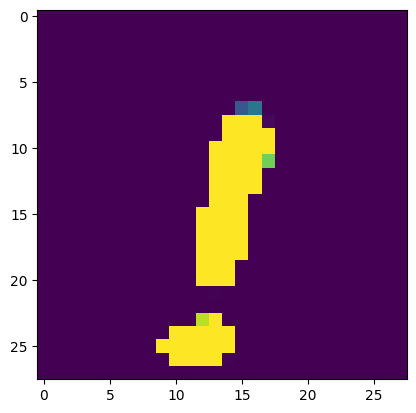

loss at end of epoch 58: 19788.939453125
test loss at end of epoch 58: 19072.00390625
RECONSTRUCTED


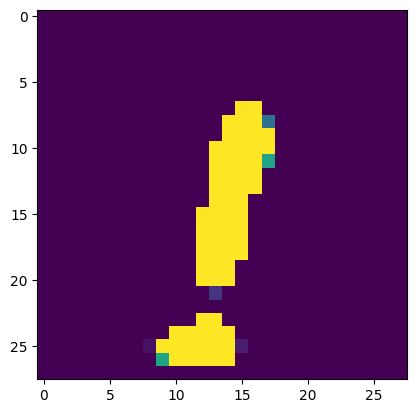

loss at end of epoch 59: 19885.16015625
test loss at end of epoch 59: 20207.69921875
RECONSTRUCTED


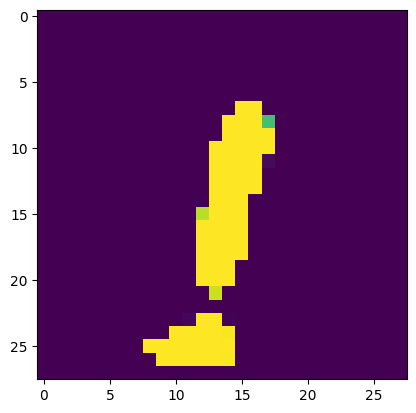

loss at end of epoch 60: 19408.17578125
test loss at end of epoch 60: 20005.388671875
RECONSTRUCTED


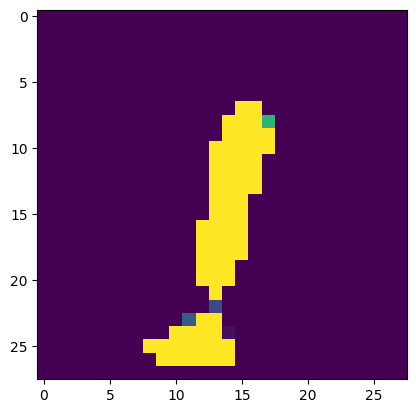

loss at end of epoch 61: 18968.08203125
test loss at end of epoch 61: 19815.021484375
RECONSTRUCTED


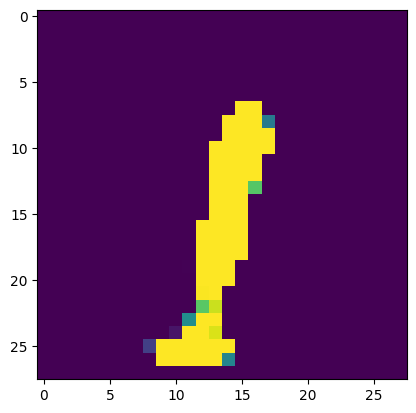

loss at end of epoch 62: 19081.40625
test loss at end of epoch 62: 19134.80078125
RECONSTRUCTED


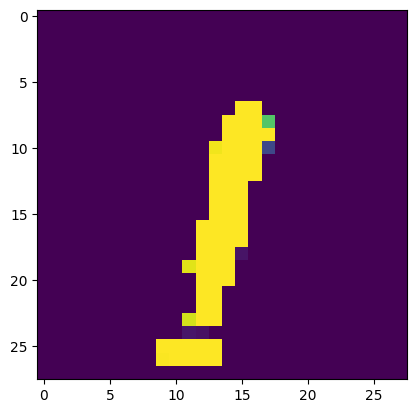

loss at end of epoch 63: 19460.38671875
test loss at end of epoch 63: 18655.458984375
RECONSTRUCTED


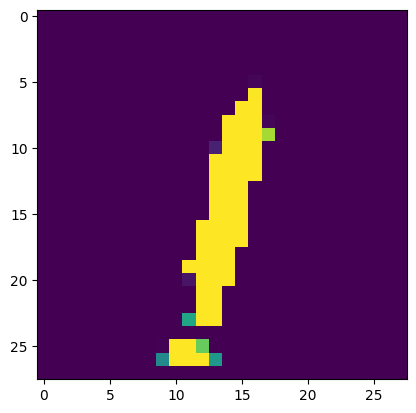

loss at end of epoch 64: 19087.380859375
test loss at end of epoch 64: 20605.5078125
RECONSTRUCTED


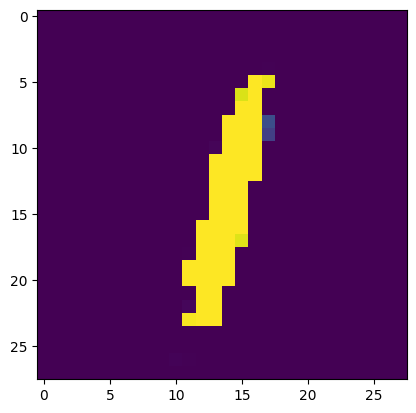

loss at end of epoch 65: 19657.373046875
test loss at end of epoch 65: 18843.630859375
RECONSTRUCTED


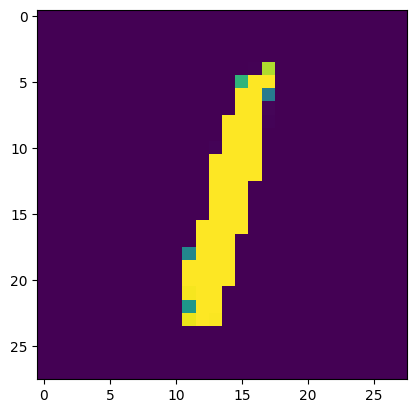

loss at end of epoch 66: 19105.134765625
test loss at end of epoch 66: 19944.451171875
RECONSTRUCTED


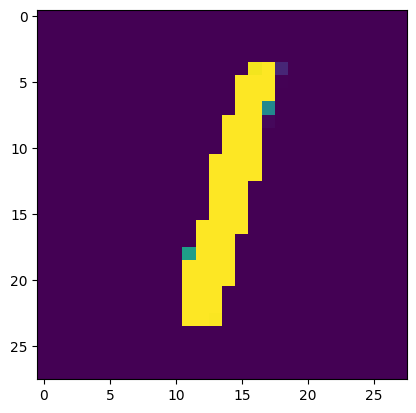

loss at end of epoch 67: 19478.232421875
test loss at end of epoch 67: 19911.810546875
RECONSTRUCTED


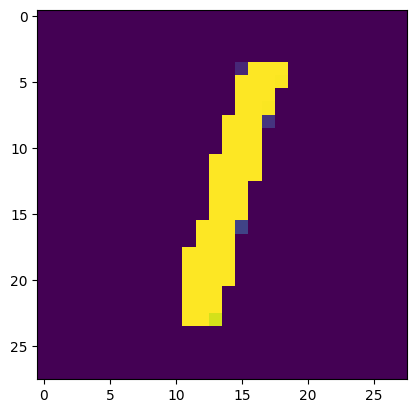

loss at end of epoch 68: 19305.01953125
test loss at end of epoch 68: 19743.77734375
RECONSTRUCTED


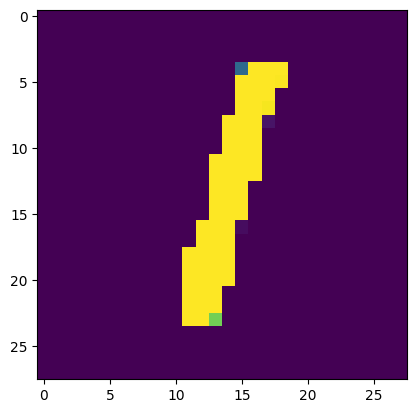

loss at end of epoch 69: 19572.66796875
test loss at end of epoch 69: 19080.26171875
RECONSTRUCTED


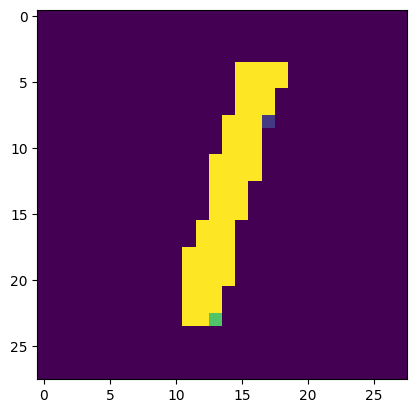

loss at end of epoch 70: 19421.75
test loss at end of epoch 70: 18724.560546875
RECONSTRUCTED


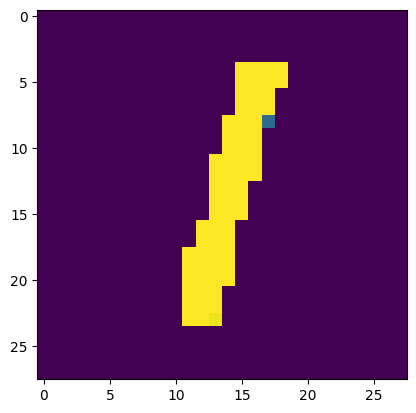

loss at end of epoch 71: 19375.177734375
test loss at end of epoch 71: 19436.23046875
RECONSTRUCTED


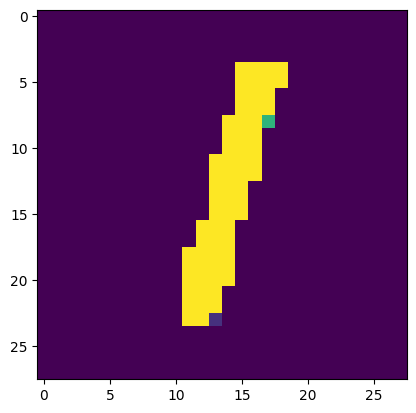

loss at end of epoch 72: 19544.927734375
test loss at end of epoch 72: 19892.275390625
RECONSTRUCTED


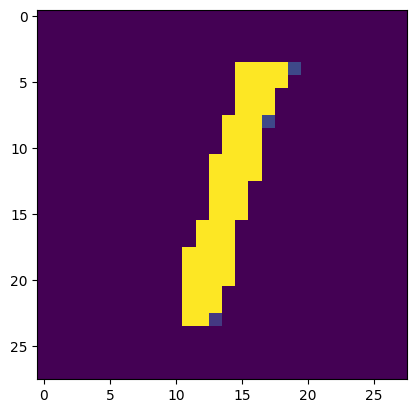

loss at end of epoch 73: 18918.78125
test loss at end of epoch 73: 18832.2890625
RECONSTRUCTED


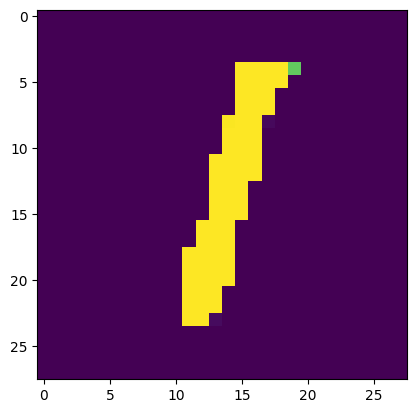

loss at end of epoch 74: 19034.45703125
test loss at end of epoch 74: 18996.953125
RECONSTRUCTED


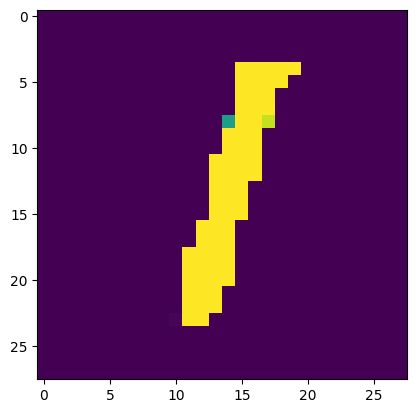

loss at end of epoch 75: 19431.83203125
test loss at end of epoch 75: 19426.595703125
RECONSTRUCTED


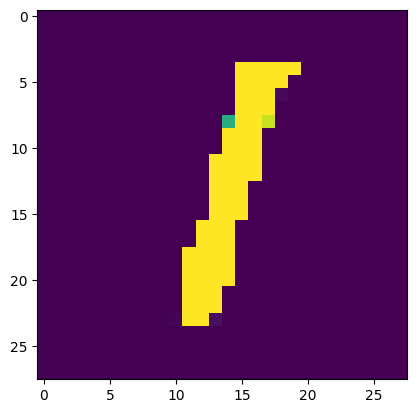

loss at end of epoch 76: 19294.197265625
test loss at end of epoch 76: 18918.392578125
RECONSTRUCTED


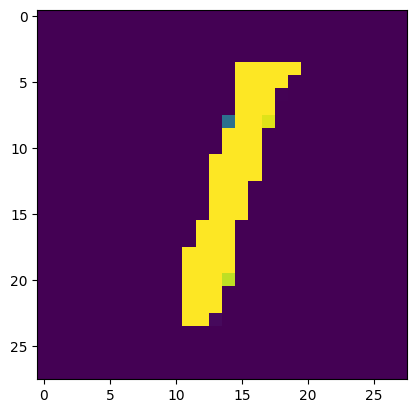

loss at end of epoch 77: 19622.89453125
test loss at end of epoch 77: 19049.833984375
RECONSTRUCTED


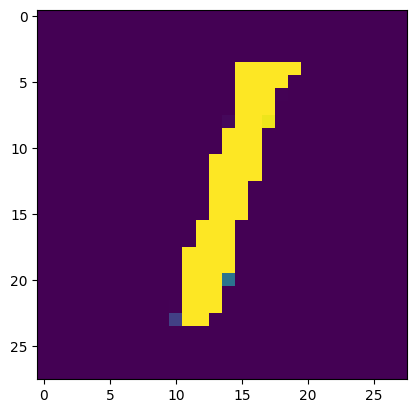

loss at end of epoch 78: 19128.931640625
test loss at end of epoch 78: 19282.935546875
RECONSTRUCTED


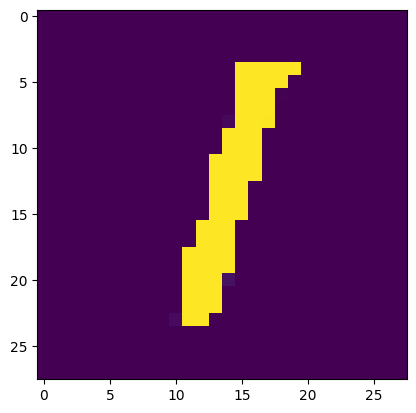

loss at end of epoch 79: 19835.978515625
test loss at end of epoch 79: 19047.74609375
RECONSTRUCTED


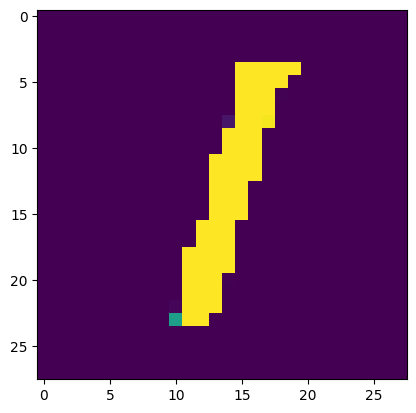

loss at end of epoch 80: 18459.375
test loss at end of epoch 80: 18640.134765625
RECONSTRUCTED


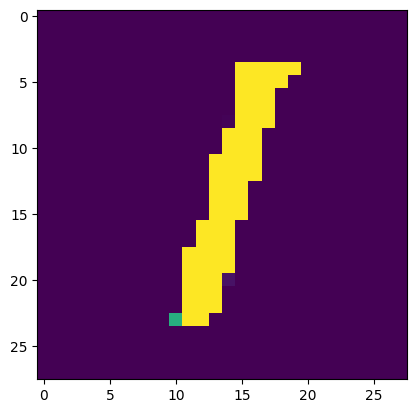

loss at end of epoch 81: 18368.669921875
test loss at end of epoch 81: 19389.658203125
RECONSTRUCTED


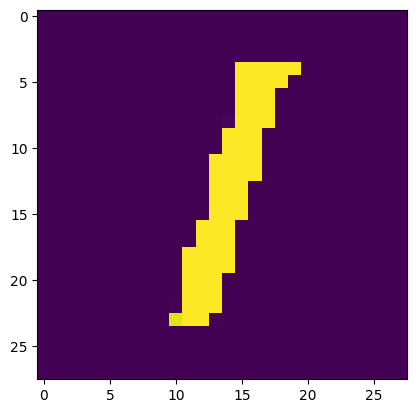

loss at end of epoch 82: 20009.78515625
test loss at end of epoch 82: 18912.314453125
RECONSTRUCTED


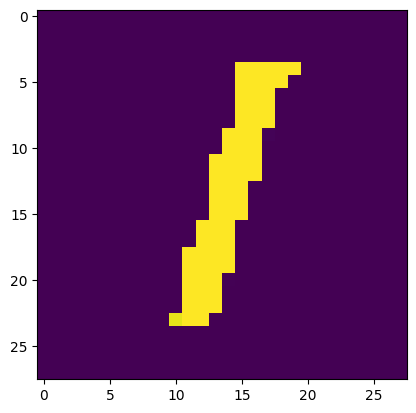

loss at end of epoch 83: 18661.94140625
test loss at end of epoch 83: 19306.857421875
RECONSTRUCTED


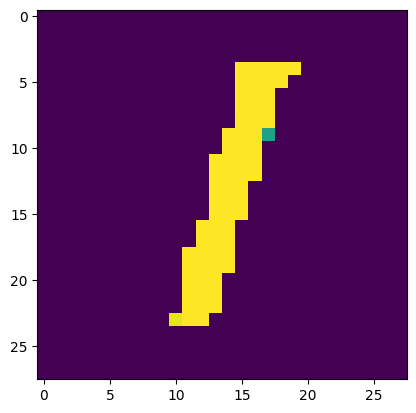

loss at end of epoch 84: 18712.388671875
test loss at end of epoch 84: 18635.1875
RECONSTRUCTED


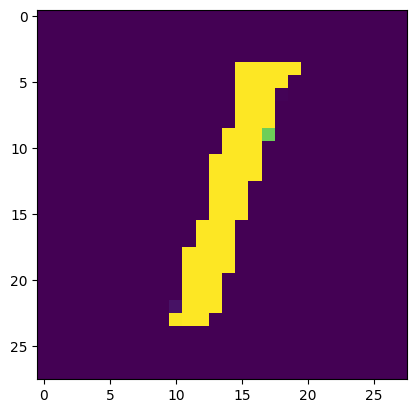

loss at end of epoch 85: 19040.958984375
test loss at end of epoch 85: 18591.8125
RECONSTRUCTED


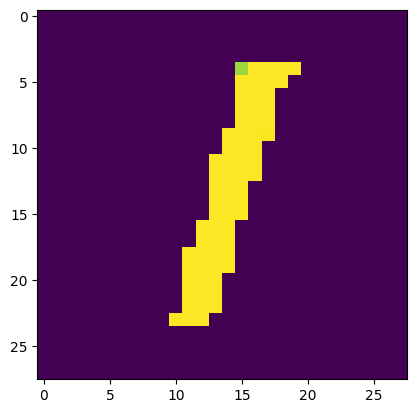

loss at end of epoch 86: 18693.697265625
test loss at end of epoch 86: 19138.037109375
RECONSTRUCTED


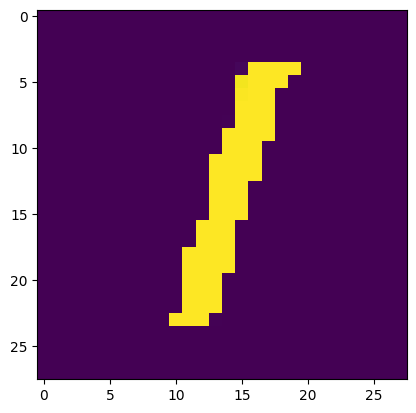

loss at end of epoch 87: 19017.416015625
test loss at end of epoch 87: 19486.736328125
RECONSTRUCTED


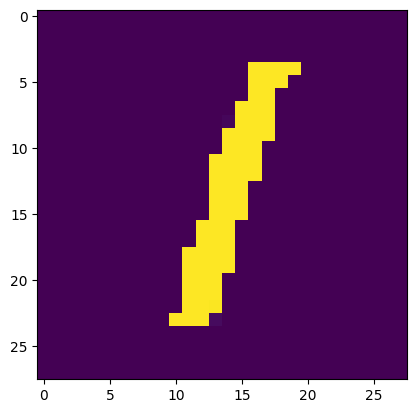

loss at end of epoch 88: 18976.55078125
test loss at end of epoch 88: 19404.138671875
RECONSTRUCTED


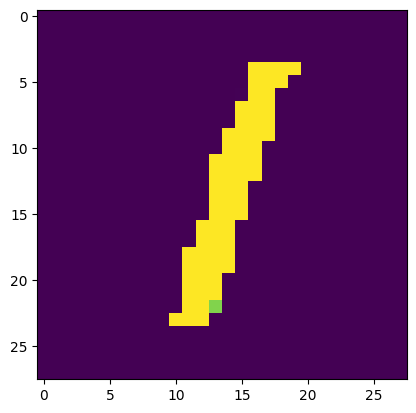

loss at end of epoch 89: 19132.541015625
test loss at end of epoch 89: 19003.88671875
RECONSTRUCTED


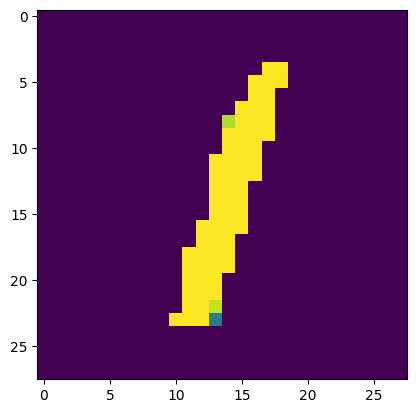

loss at end of epoch 90: 19221.162109375
test loss at end of epoch 90: 18836.400390625
RECONSTRUCTED


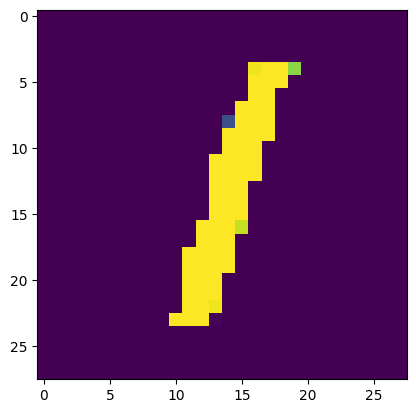

loss at end of epoch 91: 19116.693359375
test loss at end of epoch 91: 20026.26953125
RECONSTRUCTED


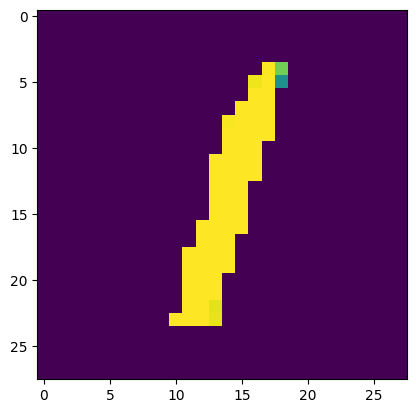

loss at end of epoch 92: 19286.216796875
test loss at end of epoch 92: 18908.666015625
RECONSTRUCTED


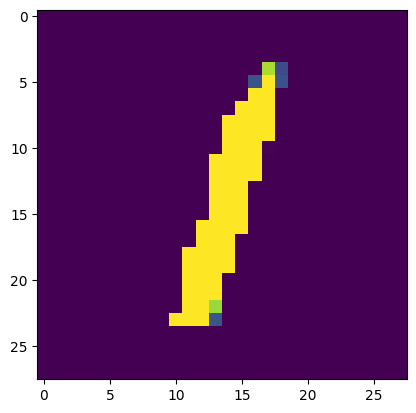

loss at end of epoch 93: 18842.17578125
test loss at end of epoch 93: 19344.25390625
RECONSTRUCTED


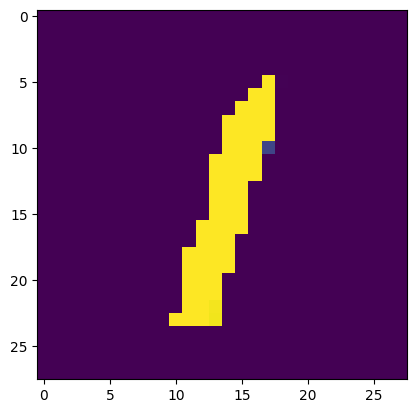

loss at end of epoch 94: 18798.033203125
test loss at end of epoch 94: 19693.037109375
RECONSTRUCTED


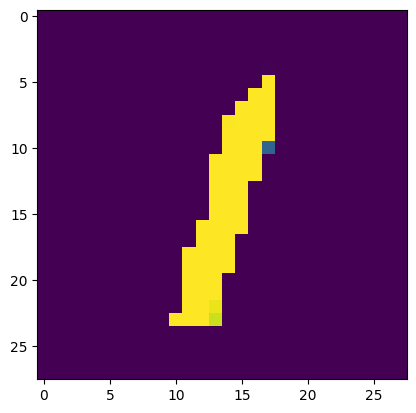

loss at end of epoch 95: 18630.666015625
test loss at end of epoch 95: 18628.048828125
RECONSTRUCTED


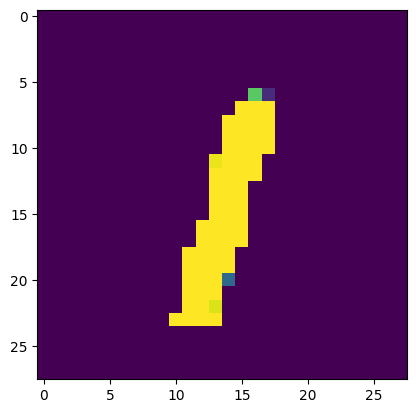

loss at end of epoch 96: 18763.373046875
test loss at end of epoch 96: 18798.36328125
RECONSTRUCTED


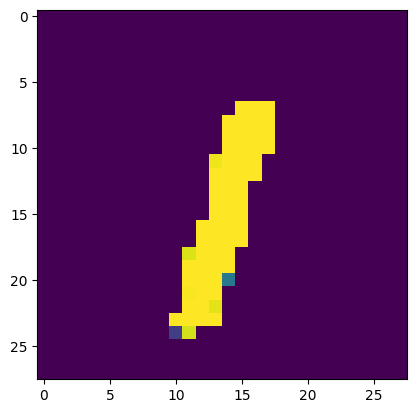

loss at end of epoch 97: 20063.712890625
test loss at end of epoch 97: 18875.912109375
RECONSTRUCTED


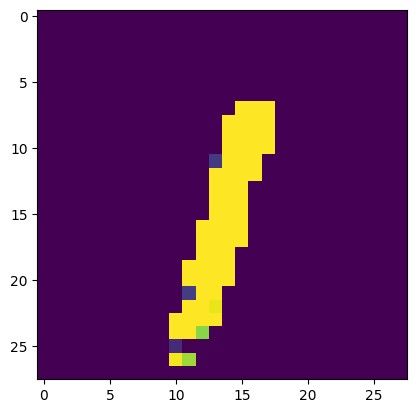

loss at end of epoch 98: 19096.259765625
test loss at end of epoch 98: 18640.103515625
RECONSTRUCTED


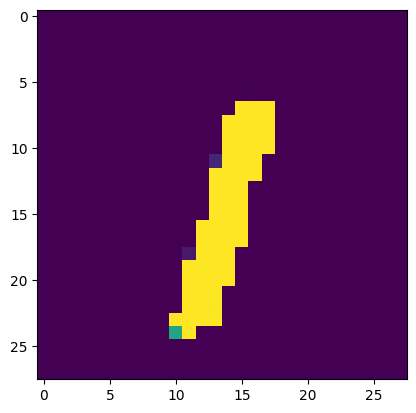

loss at end of epoch 99: 18876.376953125
test loss at end of epoch 99: 19734.720703125
RECONSTRUCTED


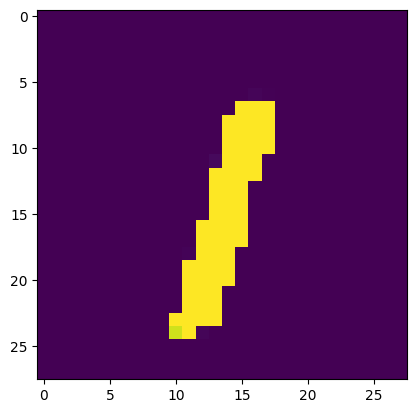

loss at end of epoch 100: 19699.0625
test loss at end of epoch 100: 19094.12109375
RECONSTRUCTED


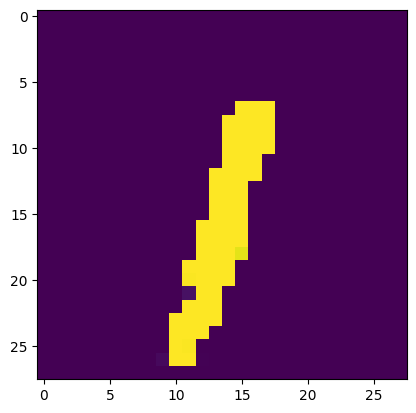

alpha: tensor([0.2984, 0.3868, 0.2984, 0.2984, 0.2984, 1.6867, 0.2984, 0.2984, 0.6457,
        0.9930, 0.2984, 0.9930, 0.2984, 1.3403, 0.6457, 0.2986, 0.2984, 0.6457,
        0.3164, 0.6457, 0.9930, 1.3402, 0.2984, 0.3030, 0.6457, 0.3021, 1.3403,
        0.9920, 0.6457, 0.9930, 0.6456, 0.2984, 0.9930, 0.9934, 0.9930, 0.6457,
        0.9930, 0.6458, 0.9929, 0.2984, 0.2984, 0.2984, 0.6512, 0.2984, 1.9426,
        0.2984, 0.9883, 0.6457, 0.6457, 2.0295], device='cuda:0')
loss at end of epoch 101: 19418.251953125
test loss at end of epoch 101: 18145.822265625
RECONSTRUCTED


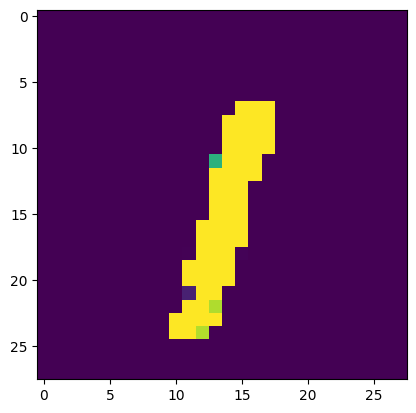

loss at end of epoch 102: 19015.4140625
test loss at end of epoch 102: 19292.41015625
RECONSTRUCTED


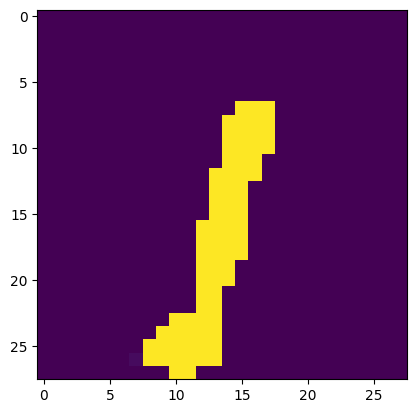

loss at end of epoch 103: 18945.0390625
test loss at end of epoch 103: 19228.205078125
RECONSTRUCTED


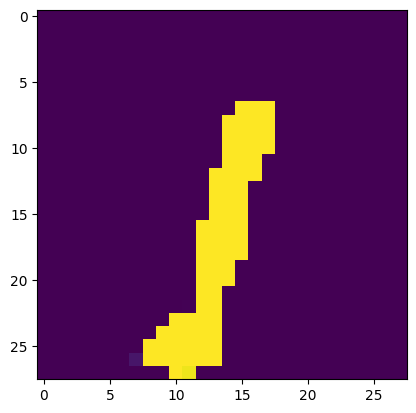

loss at end of epoch 104: 20071.568359375
test loss at end of epoch 104: 19334.466796875
RECONSTRUCTED


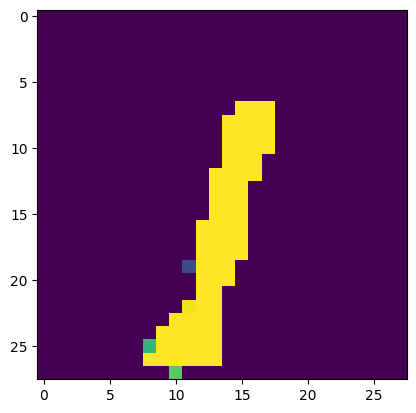

loss at end of epoch 105: 19633.5
test loss at end of epoch 105: 20066.626953125
RECONSTRUCTED


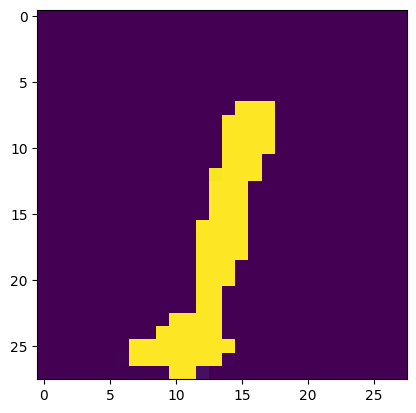

loss at end of epoch 106: 19111.876953125
test loss at end of epoch 106: 18556.68359375
RECONSTRUCTED


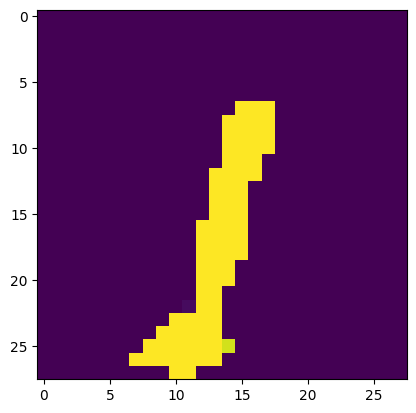

loss at end of epoch 107: 18550.501953125
test loss at end of epoch 107: 18345.791015625
RECONSTRUCTED


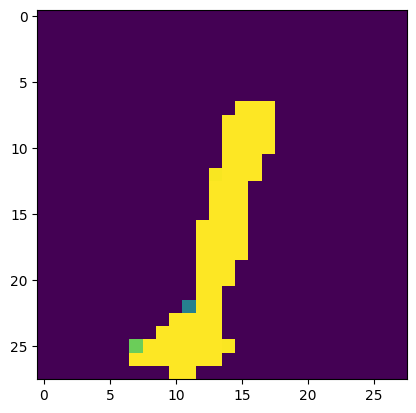

loss at end of epoch 108: 18207.3046875
test loss at end of epoch 108: 18883.62109375
RECONSTRUCTED


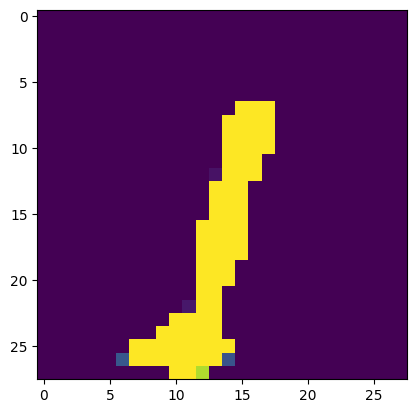

loss at end of epoch 109: 19050.37109375
test loss at end of epoch 109: 18350.087890625
RECONSTRUCTED


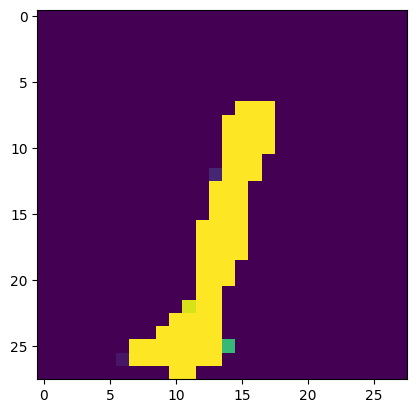

loss at end of epoch 110: 18408.02734375
test loss at end of epoch 110: 18697.125
RECONSTRUCTED


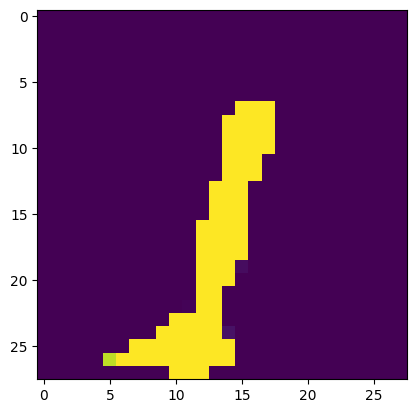

loss at end of epoch 111: 18239.9921875
test loss at end of epoch 111: 18139.484375
RECONSTRUCTED


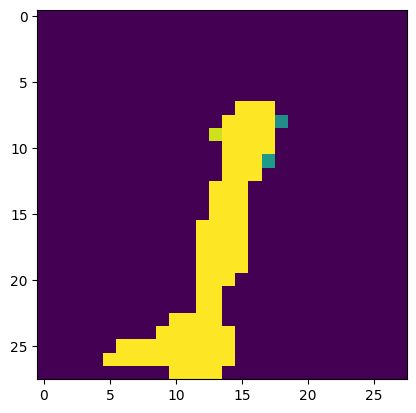

loss at end of epoch 112: 18659.740234375
test loss at end of epoch 112: 18270.0
RECONSTRUCTED


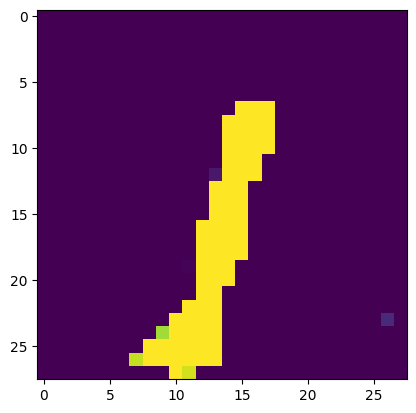

loss at end of epoch 113: 19181.09765625
test loss at end of epoch 113: 19657.734375
RECONSTRUCTED


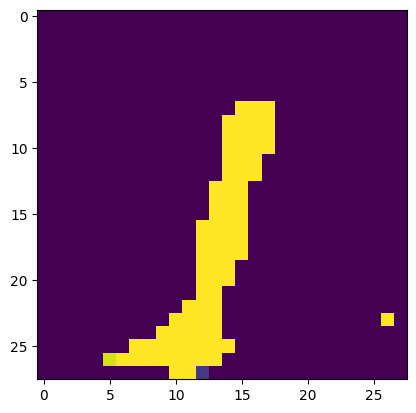

loss at end of epoch 114: 17965.2421875
test loss at end of epoch 114: 19428.06640625
RECONSTRUCTED


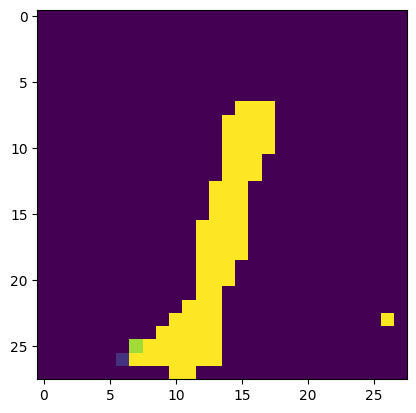

loss at end of epoch 115: 18323.626953125
test loss at end of epoch 115: 18764.751953125
RECONSTRUCTED


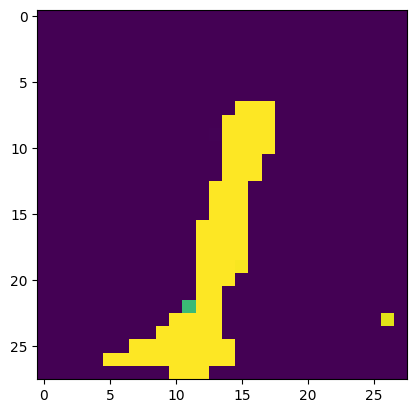

loss at end of epoch 116: 18760.986328125
test loss at end of epoch 116: 19341.9765625
RECONSTRUCTED


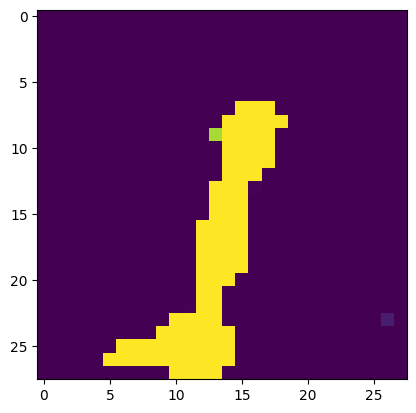

loss at end of epoch 117: 18833.6796875
test loss at end of epoch 117: 18267.908203125
RECONSTRUCTED


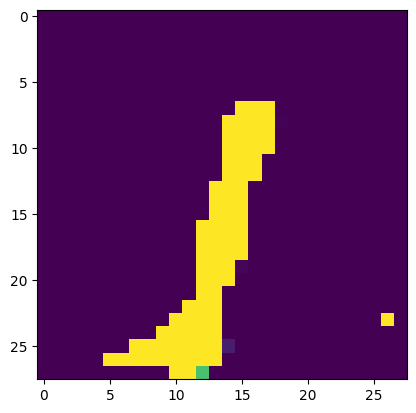

loss at end of epoch 118: 18571.0546875
test loss at end of epoch 118: 18504.064453125
RECONSTRUCTED


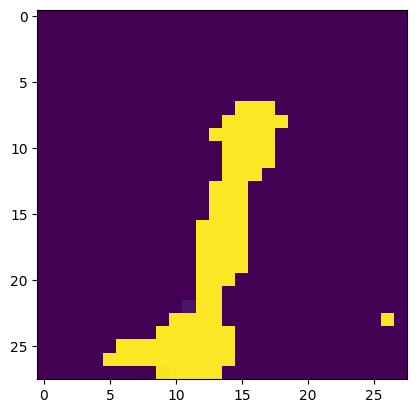

loss at end of epoch 119: 19243.08203125
test loss at end of epoch 119: 18382.04296875
RECONSTRUCTED


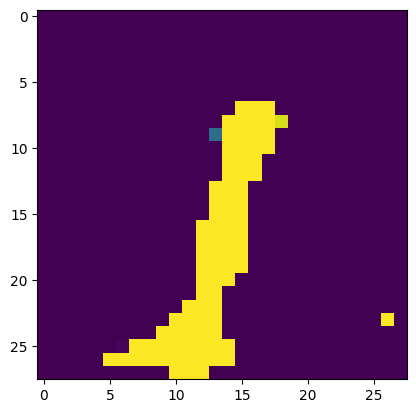

loss at end of epoch 120: 18916.828125
test loss at end of epoch 120: 18460.81640625
RECONSTRUCTED


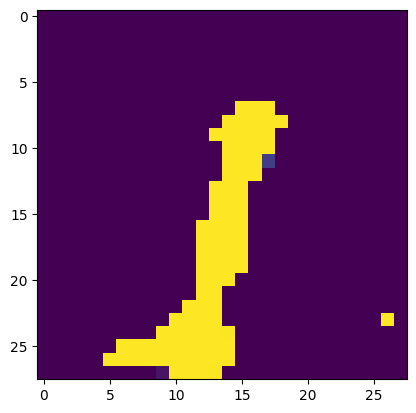

loss at end of epoch 121: 18763.177734375
test loss at end of epoch 121: 18789.2578125
RECONSTRUCTED


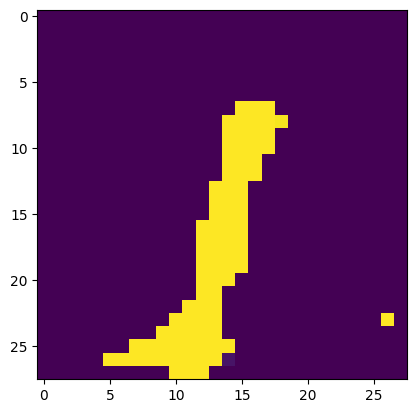

loss at end of epoch 122: 18385.9375
test loss at end of epoch 122: 18976.93359375
RECONSTRUCTED


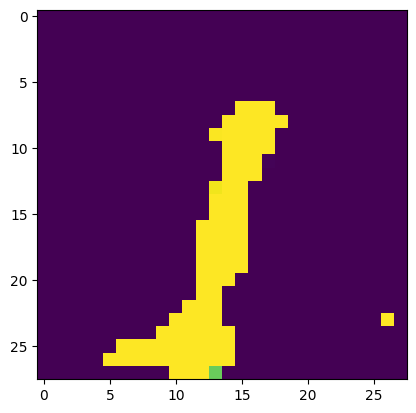

loss at end of epoch 123: 18884.76171875
test loss at end of epoch 123: 19262.09375
RECONSTRUCTED


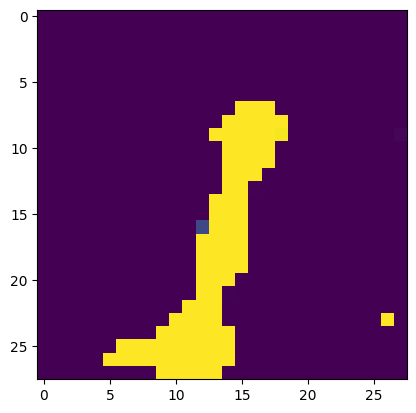

loss at end of epoch 124: 18430.408203125
test loss at end of epoch 124: 17995.849609375
RECONSTRUCTED


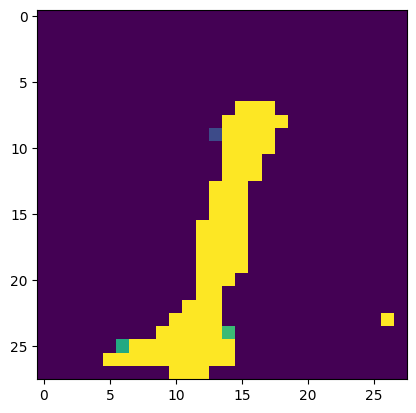

loss at end of epoch 125: 19375.470703125
test loss at end of epoch 125: 18392.765625
RECONSTRUCTED


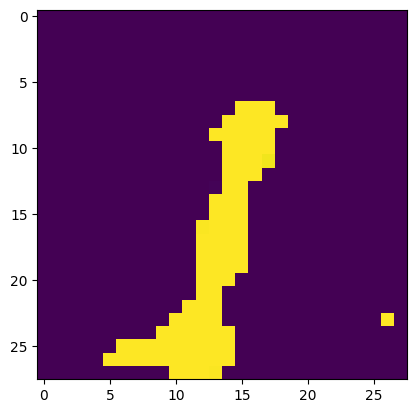

loss at end of epoch 126: 19389.49609375
test loss at end of epoch 126: 18354.75
RECONSTRUCTED


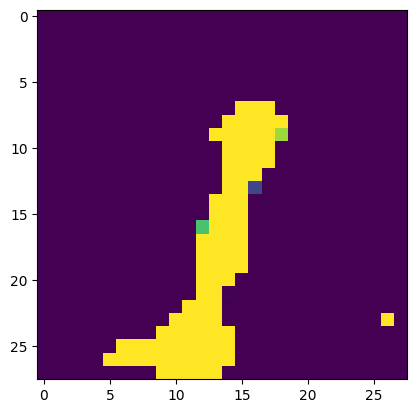

loss at end of epoch 127: 18929.48828125
test loss at end of epoch 127: 19216.9296875
RECONSTRUCTED


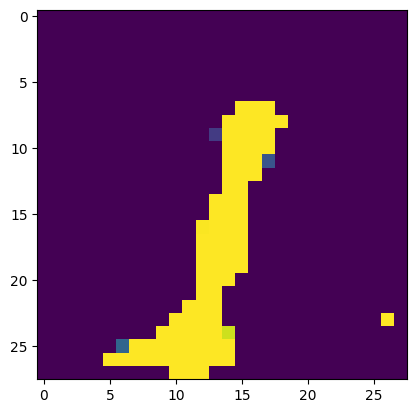

loss at end of epoch 128: 19396.3359375
test loss at end of epoch 128: 19117.53125
RECONSTRUCTED


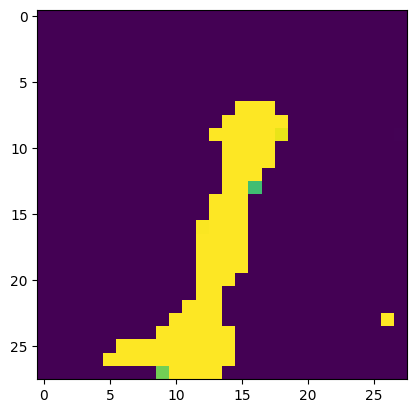

loss at end of epoch 129: 19018.025390625
test loss at end of epoch 129: 17939.099609375
RECONSTRUCTED


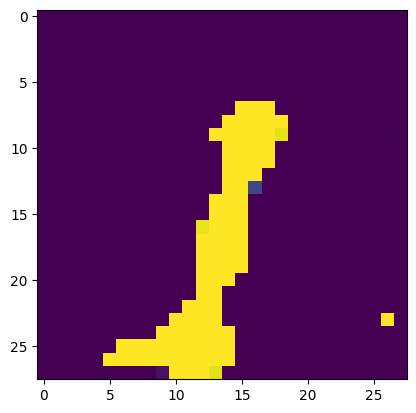

loss at end of epoch 130: 18856.41796875
test loss at end of epoch 130: 19141.65625
RECONSTRUCTED


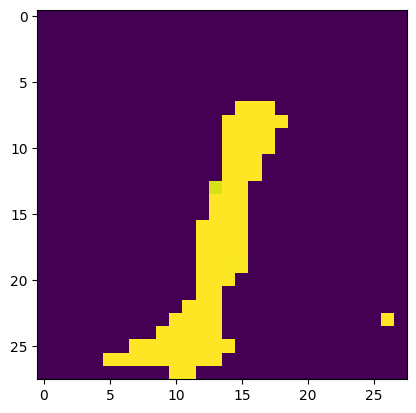

loss at end of epoch 131: 19088.189453125
test loss at end of epoch 131: 17957.91796875
RECONSTRUCTED


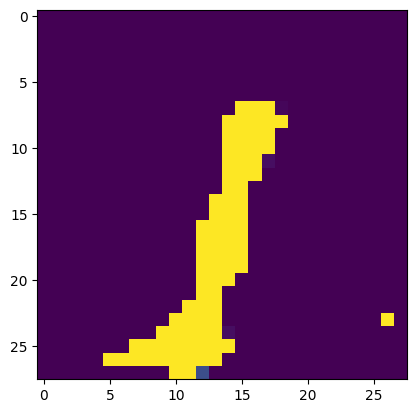

loss at end of epoch 132: 18971.970703125
test loss at end of epoch 132: 19497.03125
RECONSTRUCTED


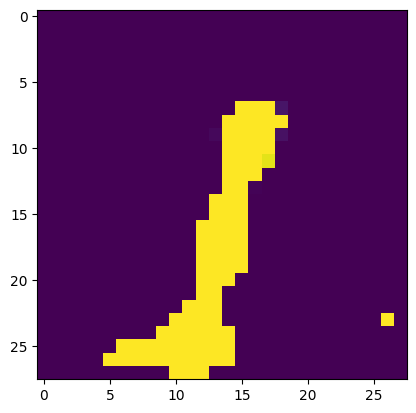

loss at end of epoch 133: 18721.421875
test loss at end of epoch 133: 18627.3828125
RECONSTRUCTED


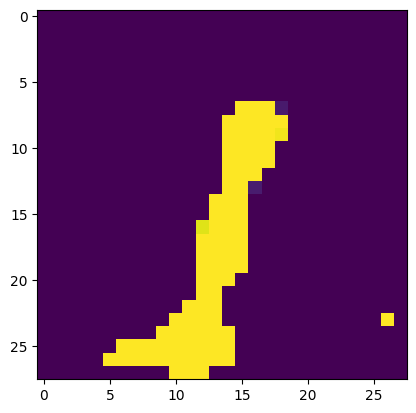

loss at end of epoch 134: 19158.79296875
test loss at end of epoch 134: 18611.52734375
RECONSTRUCTED


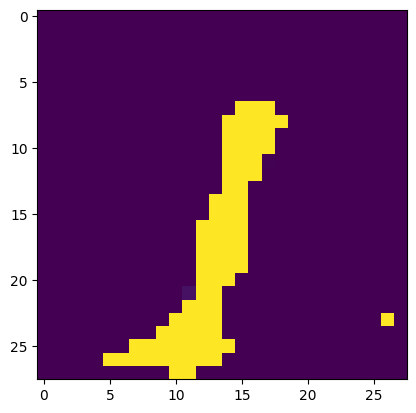

loss at end of epoch 135: 18701.107421875
test loss at end of epoch 135: 18391.7890625
RECONSTRUCTED


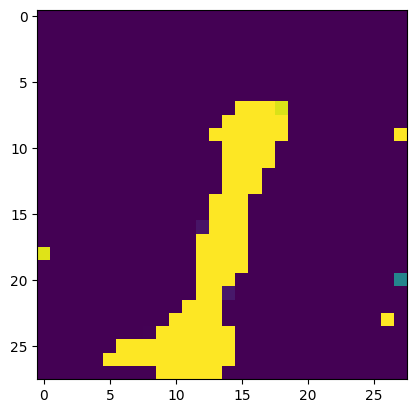

loss at end of epoch 136: 18584.126953125
test loss at end of epoch 136: 18765.03125
RECONSTRUCTED


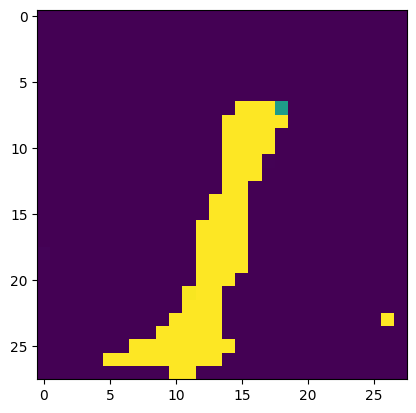

loss at end of epoch 137: 18381.82421875
test loss at end of epoch 137: 18850.109375
RECONSTRUCTED


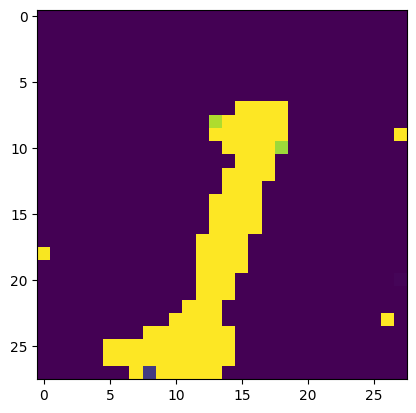

loss at end of epoch 138: 18239.953125
test loss at end of epoch 138: 19177.333984375
RECONSTRUCTED


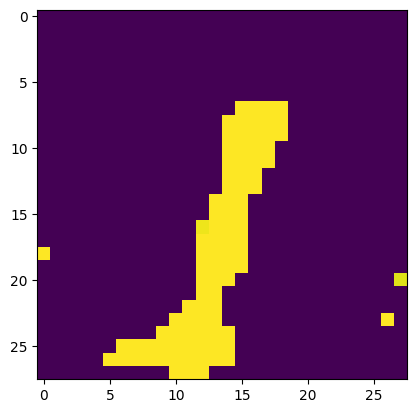

loss at end of epoch 139: 19207.1328125
test loss at end of epoch 139: 18742.537109375
RECONSTRUCTED


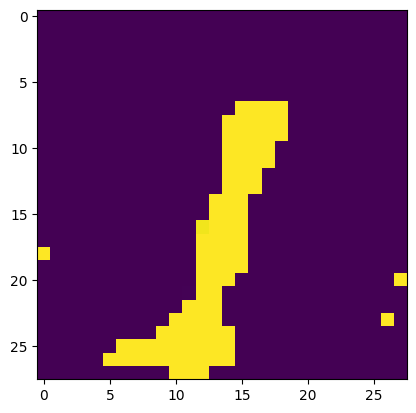

loss at end of epoch 140: 18602.935546875
test loss at end of epoch 140: 18387.8828125
RECONSTRUCTED


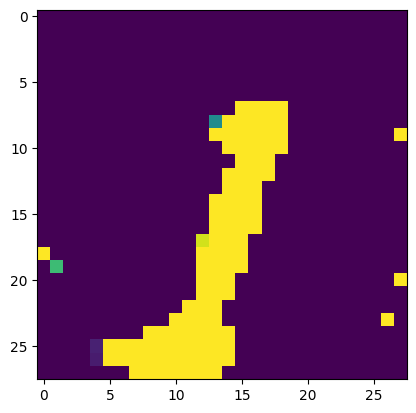

loss at end of epoch 141: 18749.708984375
test loss at end of epoch 141: 18553.326171875
RECONSTRUCTED


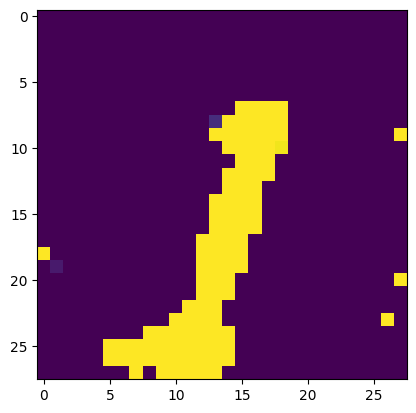

loss at end of epoch 142: 19398.5703125
test loss at end of epoch 142: 18846.607421875
RECONSTRUCTED


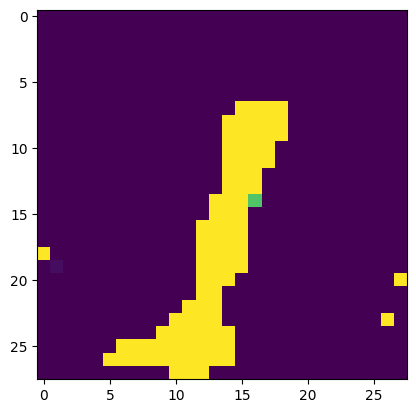

loss at end of epoch 143: 18402.482421875
test loss at end of epoch 143: 18942.56640625
RECONSTRUCTED


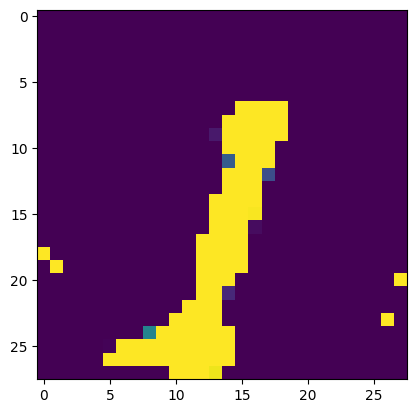

loss at end of epoch 144: 18363.5546875
test loss at end of epoch 144: 18260.451171875
RECONSTRUCTED


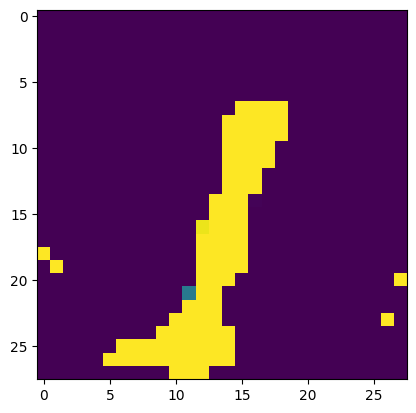

loss at end of epoch 145: 18829.541015625
test loss at end of epoch 145: 19042.40234375
RECONSTRUCTED


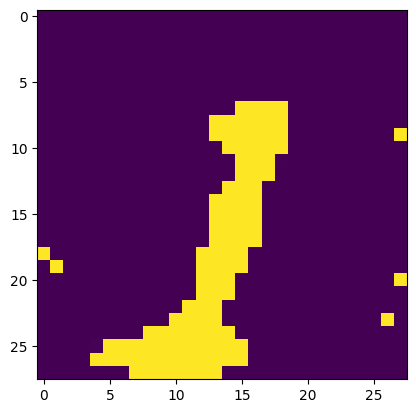

loss at end of epoch 146: 18592.275390625
test loss at end of epoch 146: 18910.078125
RECONSTRUCTED


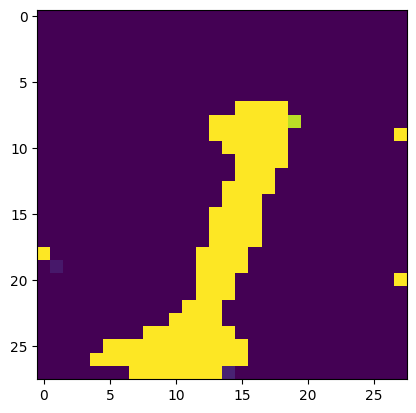

loss at end of epoch 147: 19364.30078125
test loss at end of epoch 147: 19025.908203125
RECONSTRUCTED


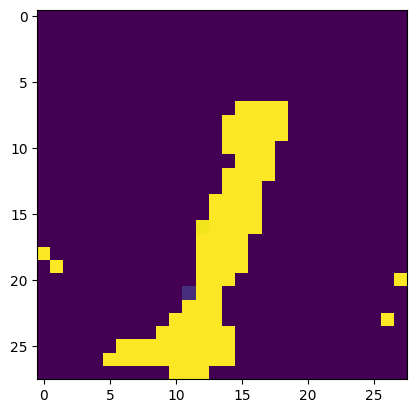

loss at end of epoch 148: 17920.99609375
test loss at end of epoch 148: 19461.65234375
RECONSTRUCTED


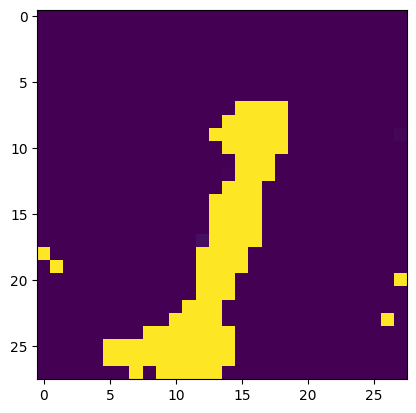

loss at end of epoch 149: 18673.869140625
test loss at end of epoch 149: 18283.146484375
RECONSTRUCTED


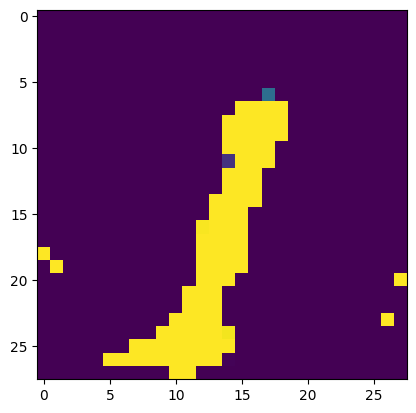

loss at end of epoch 150: 18726.716796875
test loss at end of epoch 150: 18608.427734375
RECONSTRUCTED


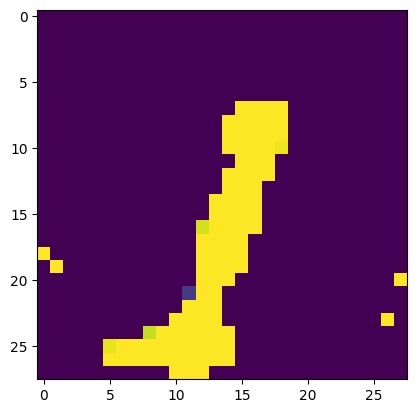

alpha: tensor([0.2817, 0.9280, 0.6048, 0.2817, 0.2817, 1.4239, 0.2817, 0.6048, 0.6049,
        0.6221, 0.6048, 0.9280, 0.6048, 1.2512, 0.9184, 0.2817, 0.9280, 0.6048,
        0.2817, 0.6048, 0.6761, 1.5744, 0.6245, 0.2817, 0.6044, 0.2817, 0.8627,
        0.9280, 0.2817, 0.6048, 0.2817, 0.6048, 0.2817, 0.2847, 2.5439, 0.6048,
        0.5335, 0.6048, 0.9279, 0.2817, 0.2817, 0.2817, 0.6048, 0.2817, 1.2510,
        0.2817, 0.6048, 0.2817, 0.9280, 0.9278], device='cuda:0')
loss at end of epoch 151: 18787.494140625
test loss at end of epoch 151: 18683.626953125
RECONSTRUCTED


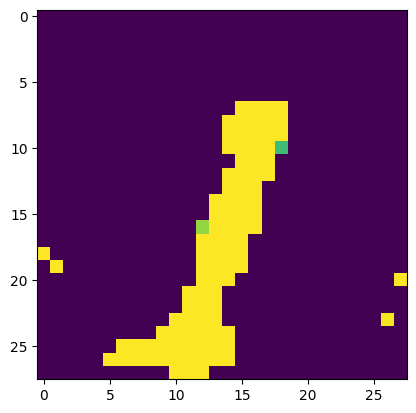

loss at end of epoch 152: 19176.71875
test loss at end of epoch 152: 18361.263671875
RECONSTRUCTED


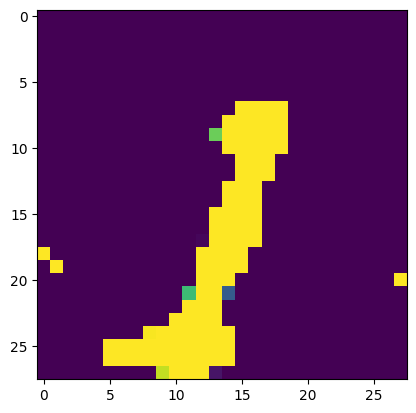

loss at end of epoch 153: 18006.36328125
test loss at end of epoch 153: 18328.923828125
RECONSTRUCTED


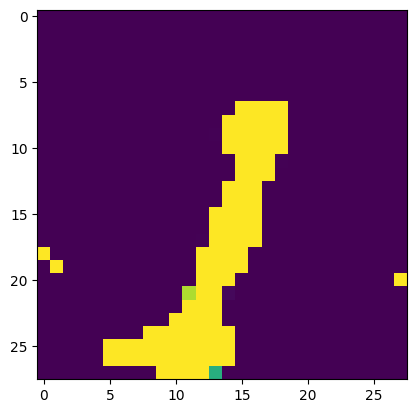

loss at end of epoch 154: 18183.4453125
test loss at end of epoch 154: 18414.494140625
RECONSTRUCTED


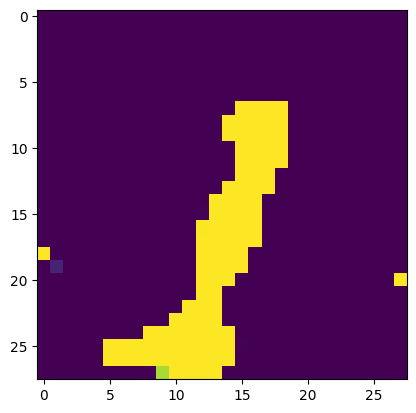

loss at end of epoch 155: 19643.18359375
test loss at end of epoch 155: 18699.04296875
RECONSTRUCTED


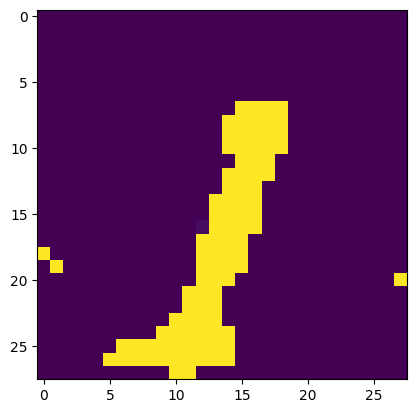

loss at end of epoch 156: 17926.66796875
test loss at end of epoch 156: 18359.197265625
RECONSTRUCTED


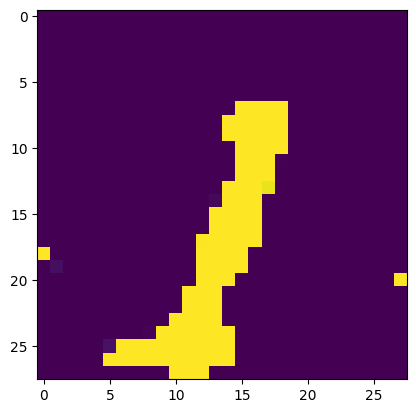

loss at end of epoch 157: 19303.44921875
test loss at end of epoch 157: 18022.9296875
RECONSTRUCTED


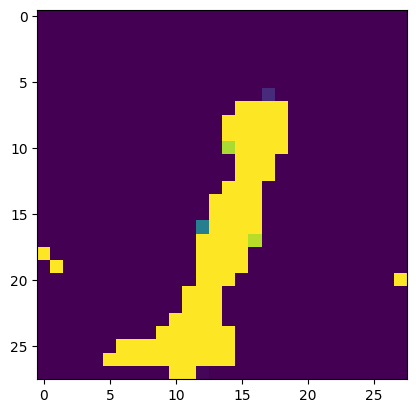

loss at end of epoch 158: 19683.990234375
test loss at end of epoch 158: 17529.390625
RECONSTRUCTED


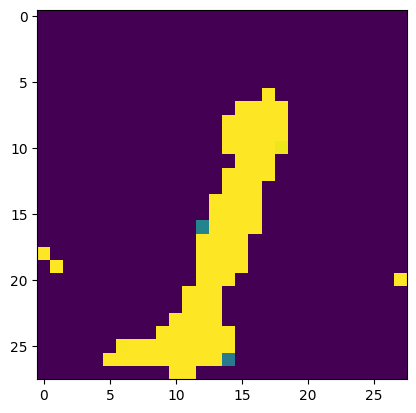

loss at end of epoch 159: 18174.357421875
test loss at end of epoch 159: 18817.08984375
RECONSTRUCTED


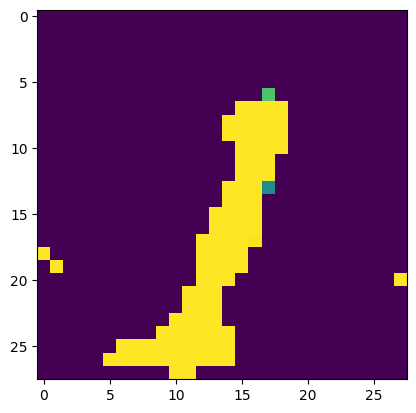

loss at end of epoch 160: 18676.388671875
test loss at end of epoch 160: 18569.703125
RECONSTRUCTED


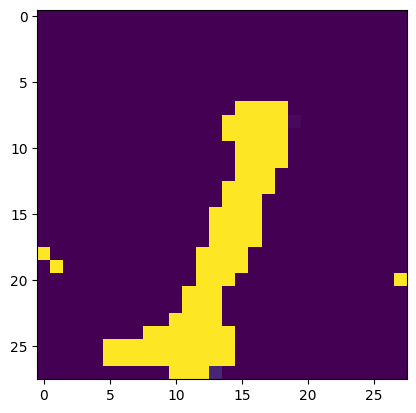

loss at end of epoch 161: 18108.314453125
test loss at end of epoch 161: 18270.74609375
RECONSTRUCTED


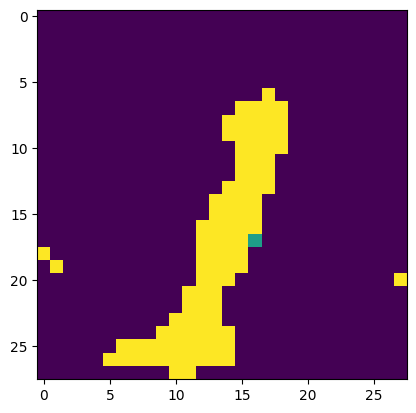

loss at end of epoch 162: 18510.7109375
test loss at end of epoch 162: 18283.70703125
RECONSTRUCTED


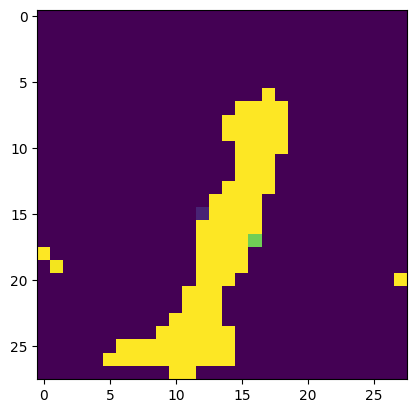

loss at end of epoch 163: 18246.474609375
test loss at end of epoch 163: 19451.2421875
RECONSTRUCTED


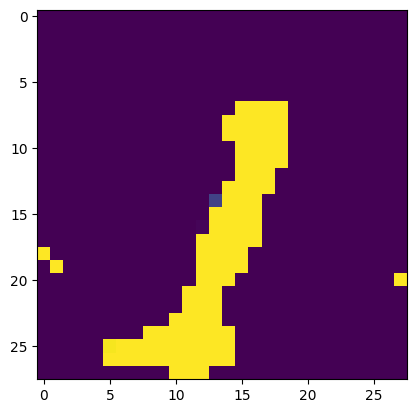

loss at end of epoch 164: 19026.26953125
test loss at end of epoch 164: 17652.130859375
RECONSTRUCTED


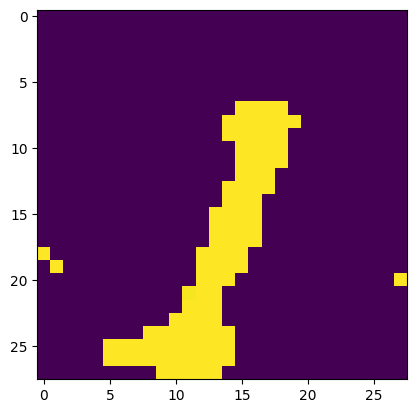

loss at end of epoch 165: 18420.69921875
test loss at end of epoch 165: 18812.962890625
RECONSTRUCTED


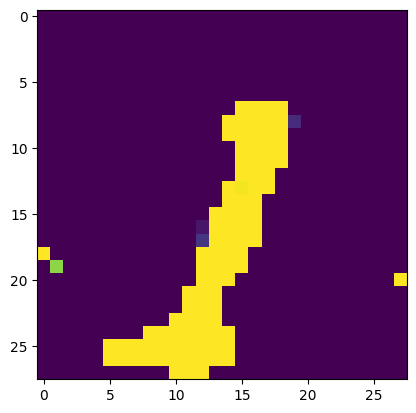

loss at end of epoch 166: 18923.365234375
test loss at end of epoch 166: 18112.580078125
RECONSTRUCTED


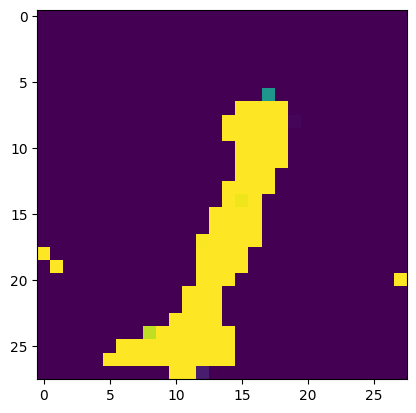

loss at end of epoch 167: 18225.958984375
test loss at end of epoch 167: 18241.48828125
RECONSTRUCTED


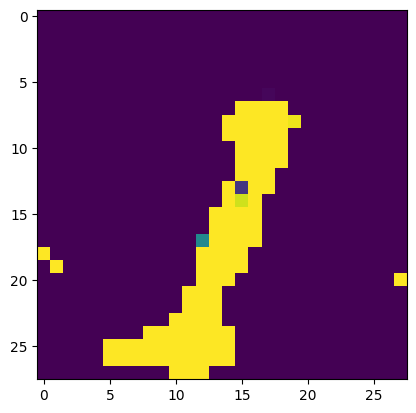

loss at end of epoch 168: 18618.232421875
test loss at end of epoch 168: 19008.1171875
RECONSTRUCTED


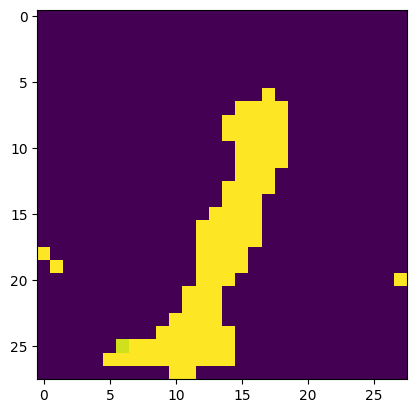

loss at end of epoch 169: 18410.69921875
test loss at end of epoch 169: 18835.021484375
RECONSTRUCTED


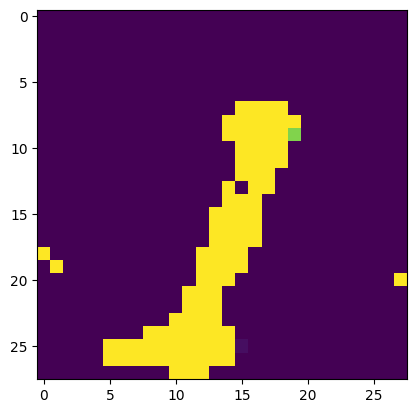

loss at end of epoch 170: 18347.345703125
test loss at end of epoch 170: 19305.775390625
RECONSTRUCTED


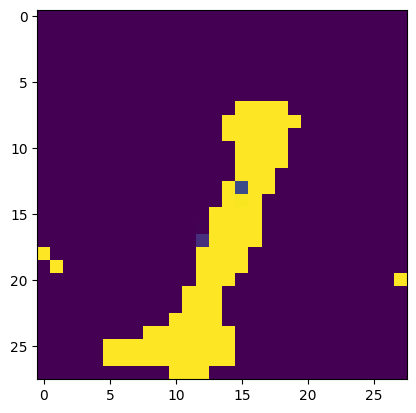

loss at end of epoch 171: 19742.41015625
test loss at end of epoch 171: 19031.109375
RECONSTRUCTED


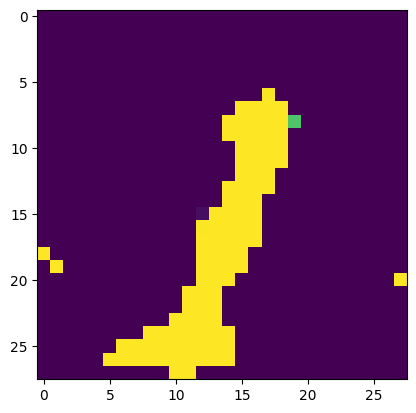

loss at end of epoch 172: 18584.310546875
test loss at end of epoch 172: 19471.63671875
RECONSTRUCTED


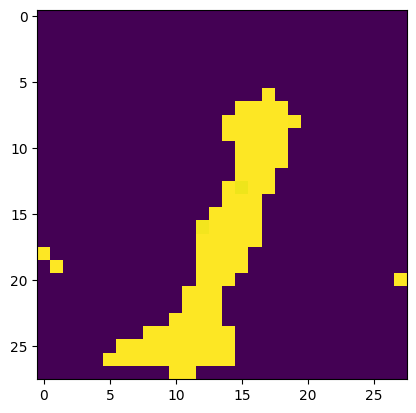

loss at end of epoch 173: 17671.384765625
test loss at end of epoch 173: 19524.3046875
RECONSTRUCTED


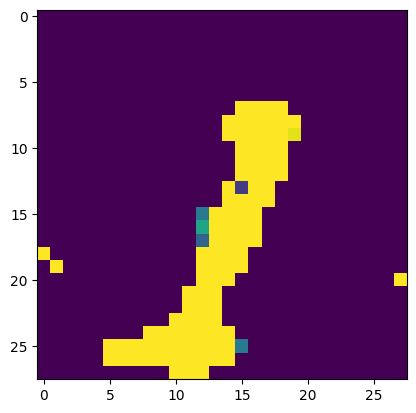

loss at end of epoch 174: 17615.265625
test loss at end of epoch 174: 19038.173828125
RECONSTRUCTED


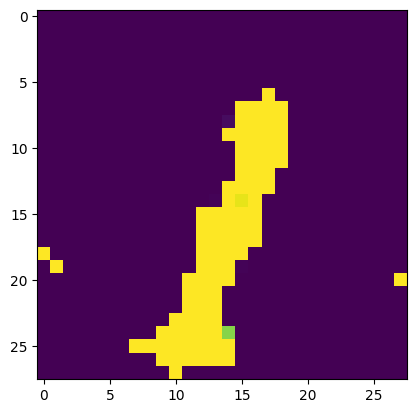

loss at end of epoch 175: 18672.517578125
test loss at end of epoch 175: 18618.474609375
RECONSTRUCTED


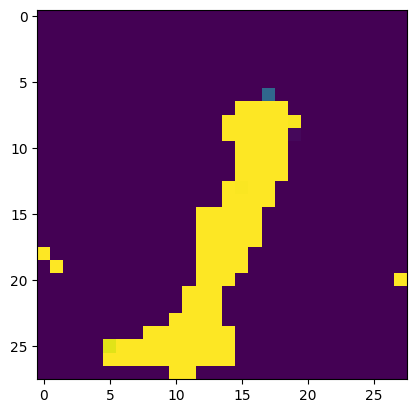

loss at end of epoch 176: 18035.857421875
test loss at end of epoch 176: 18807.615234375
RECONSTRUCTED


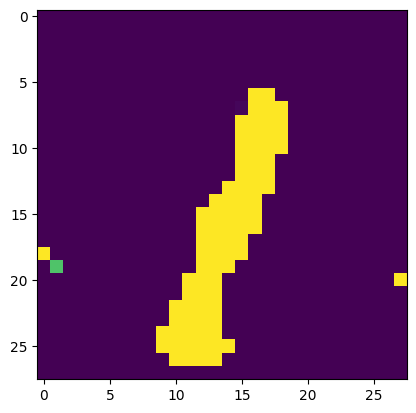

loss at end of epoch 177: 19202.078125
test loss at end of epoch 177: 19655.515625
RECONSTRUCTED


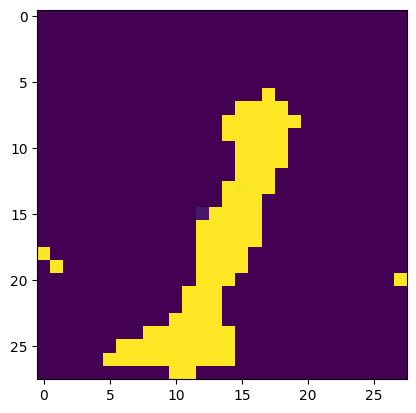

loss at end of epoch 178: 19093.267578125
test loss at end of epoch 178: 19379.203125
RECONSTRUCTED


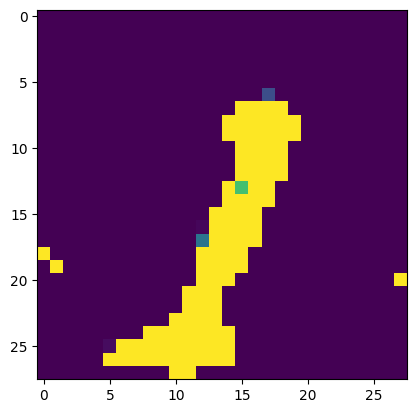

loss at end of epoch 179: 18930.314453125
test loss at end of epoch 179: 19294.345703125
RECONSTRUCTED


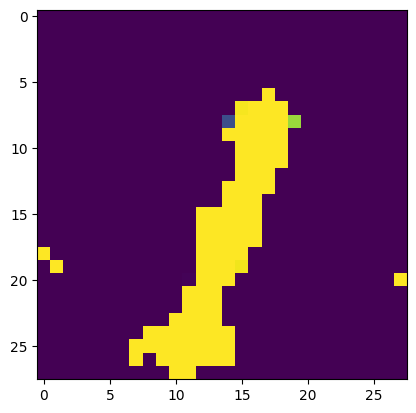

loss at end of epoch 180: 18451.595703125
test loss at end of epoch 180: 18120.751953125
RECONSTRUCTED


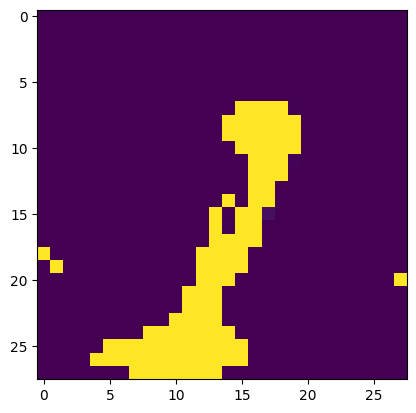

loss at end of epoch 181: 17702.373046875
test loss at end of epoch 181: 18940.9921875
RECONSTRUCTED


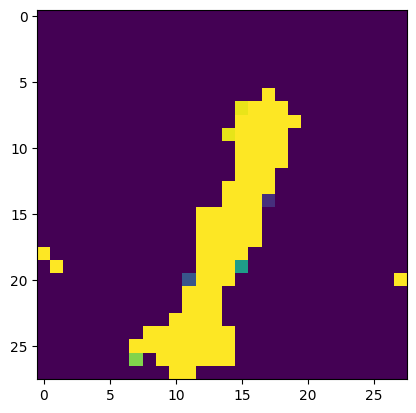

loss at end of epoch 182: 19065.431640625
test loss at end of epoch 182: 18830.12890625
RECONSTRUCTED


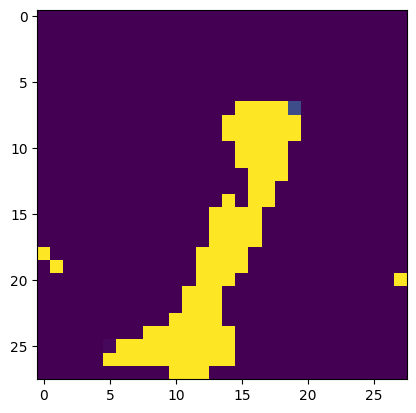

loss at end of epoch 183: 17806.884765625
test loss at end of epoch 183: 18654.388671875
RECONSTRUCTED


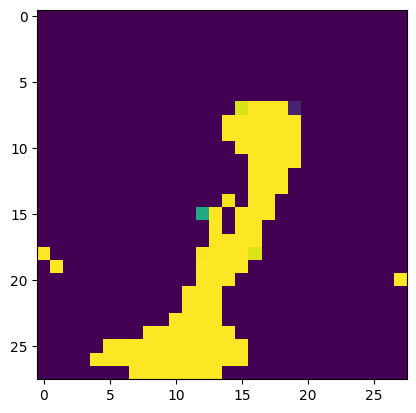

loss at end of epoch 184: 18657.03515625
test loss at end of epoch 184: 19290.478515625
RECONSTRUCTED


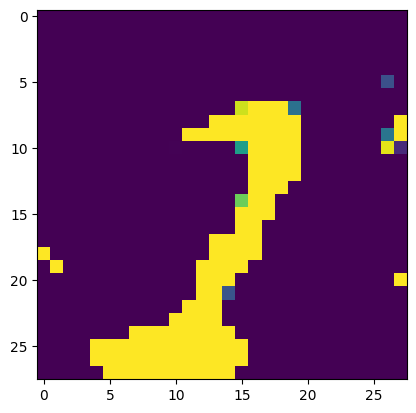

loss at end of epoch 185: 19492.607421875
test loss at end of epoch 185: 18817.599609375
RECONSTRUCTED


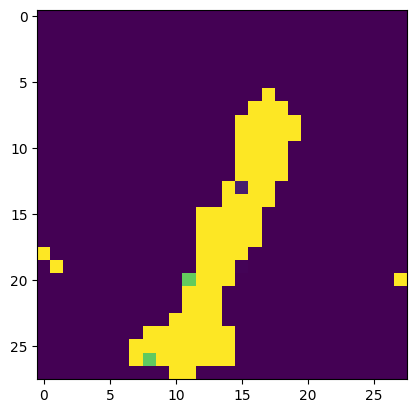

loss at end of epoch 186: 18298.173828125
test loss at end of epoch 186: 18474.771484375
RECONSTRUCTED


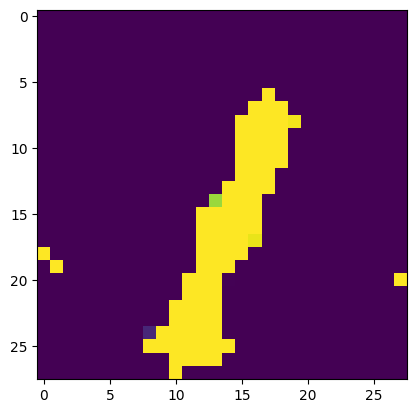

loss at end of epoch 187: 19326.8671875
test loss at end of epoch 187: 19448.75390625
RECONSTRUCTED


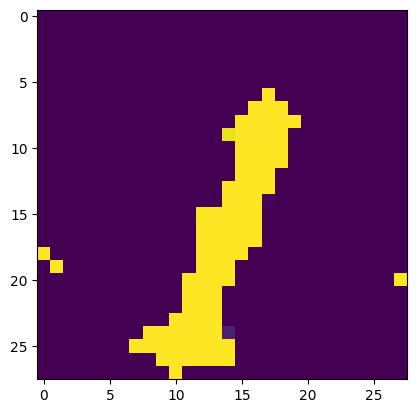

loss at end of epoch 188: 19692.88671875
test loss at end of epoch 188: 18820.576171875
RECONSTRUCTED


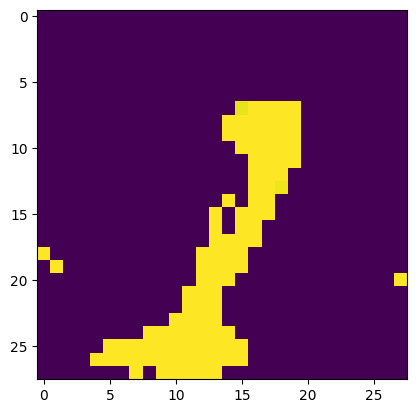

loss at end of epoch 189: 18426.7265625
test loss at end of epoch 189: 19155.134765625
RECONSTRUCTED


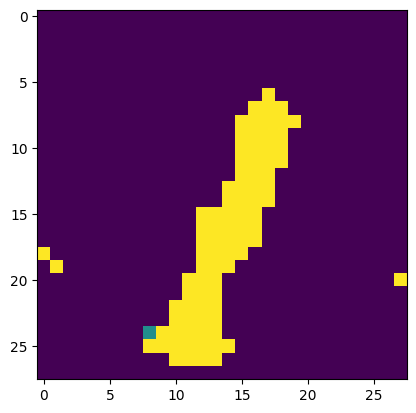

loss at end of epoch 190: 17795.146484375
test loss at end of epoch 190: 19004.232421875
RECONSTRUCTED


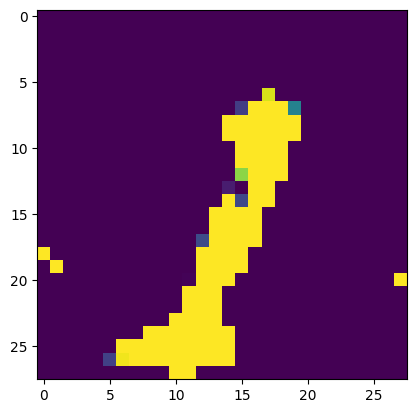

loss at end of epoch 191: 18545.443359375
test loss at end of epoch 191: 18100.099609375
RECONSTRUCTED


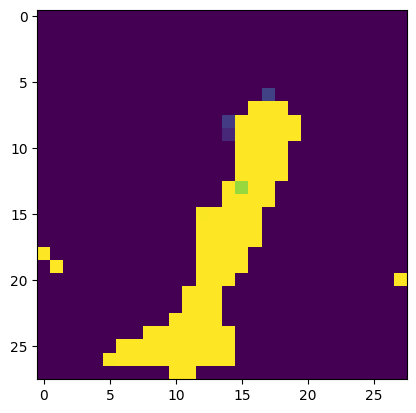

loss at end of epoch 192: 18638.5078125
test loss at end of epoch 192: 19135.544921875
RECONSTRUCTED


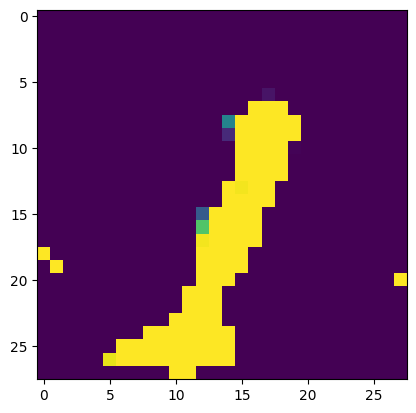

loss at end of epoch 193: 18982.05078125
test loss at end of epoch 193: 18620.763671875
RECONSTRUCTED


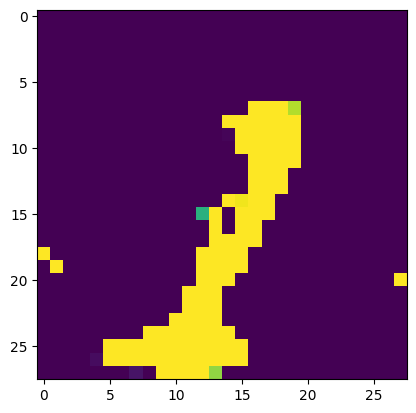

loss at end of epoch 194: 18071.3359375
test loss at end of epoch 194: 18514.85546875
RECONSTRUCTED


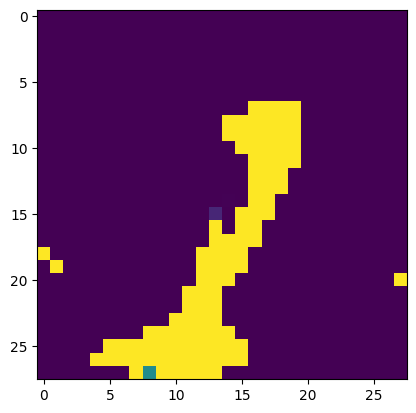

loss at end of epoch 195: 18243.265625
test loss at end of epoch 195: 18006.748046875
RECONSTRUCTED


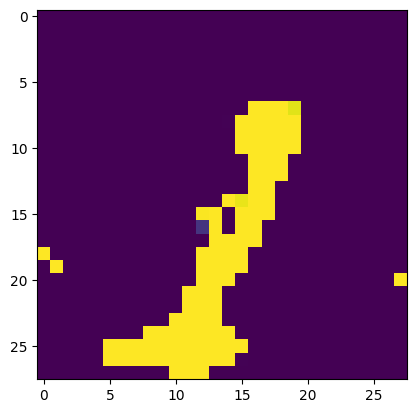

loss at end of epoch 196: 18094.998046875
test loss at end of epoch 196: 19249.7578125
RECONSTRUCTED


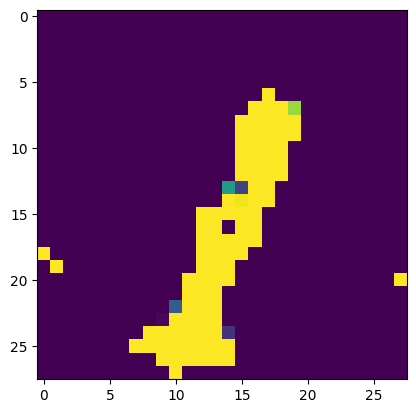

loss at end of epoch 197: 19422.16796875
test loss at end of epoch 197: 18733.578125
RECONSTRUCTED


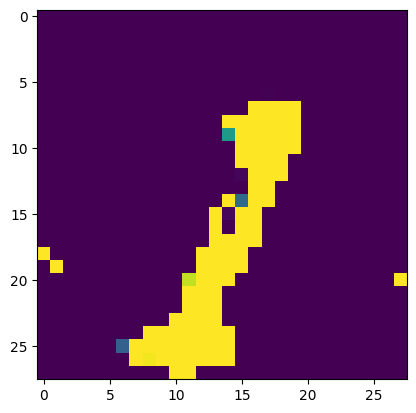

loss at end of epoch 198: 18913.626953125
test loss at end of epoch 198: 18781.75
RECONSTRUCTED


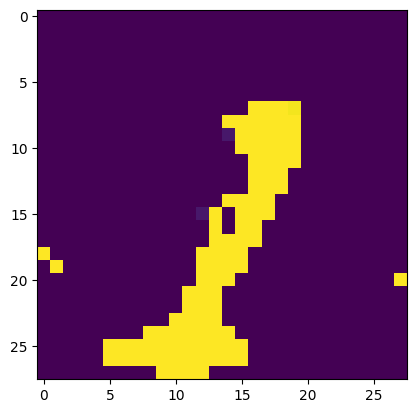

loss at end of epoch 199: 19093.53515625
test loss at end of epoch 199: 18366.40625
RECONSTRUCTED


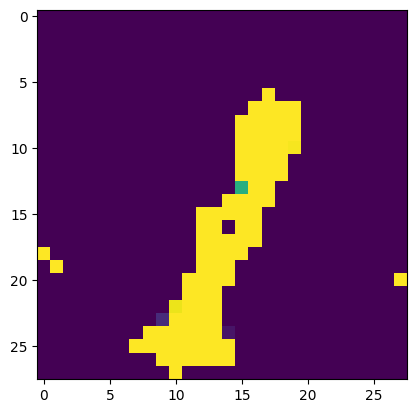

loss at end of epoch 200: 18069.150390625
test loss at end of epoch 200: 18692.251953125
RECONSTRUCTED


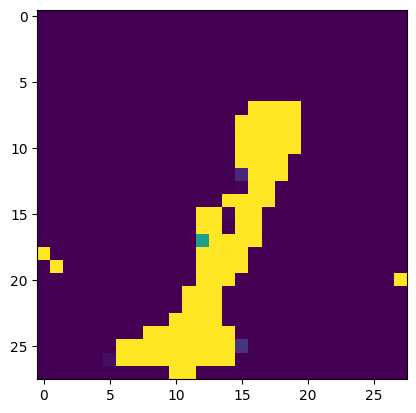

alpha: tensor([0.3884, 1.1786, 1.1786, 0.5273, 0.3884, 2.4018, 0.3884, 0.7835, 1.1786,
        0.7835, 0.7706, 0.3884, 0.3884, 1.5737, 0.3884, 0.3884, 1.1786, 0.7835,
        1.1769, 0.7761, 0.7865, 0.3884, 0.3884, 0.3884, 0.3902, 0.7835, 0.3884,
        0.7835, 0.3884, 0.7835, 0.7835, 0.7835, 0.7835, 0.3884, 2.3542, 1.1786,
        0.7835, 1.5737, 1.7922, 0.7805, 0.3884, 0.3884, 0.3884, 0.3884, 1.1338,
        0.3884, 0.7835, 0.3884, 0.7945, 0.7835], device='cuda:0')
loss at end of epoch 201: 18615.68359375
test loss at end of epoch 201: 18423.984375
RECONSTRUCTED


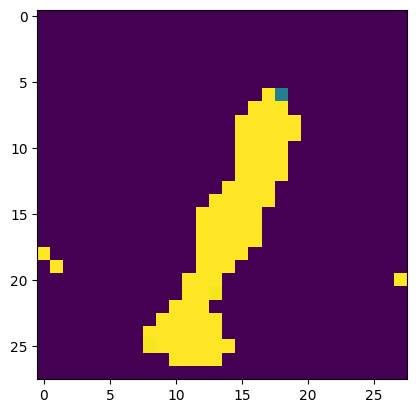

loss at end of epoch 202: 18386.369140625
test loss at end of epoch 202: 19223.49609375
RECONSTRUCTED


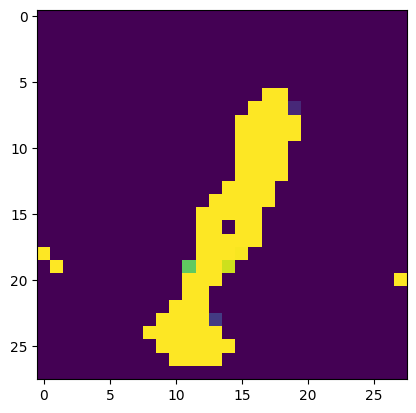

loss at end of epoch 203: 19159.7265625
test loss at end of epoch 203: 19825.337890625
RECONSTRUCTED


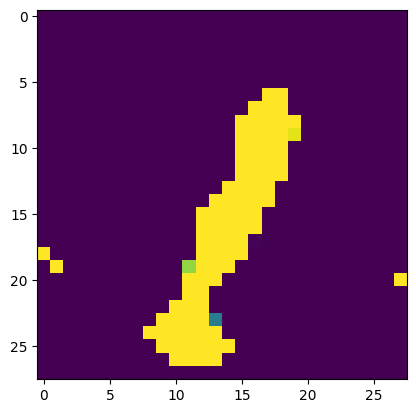

loss at end of epoch 204: 18515.388671875
test loss at end of epoch 204: 18343.611328125
RECONSTRUCTED


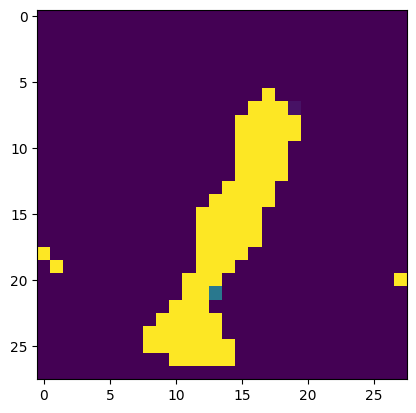

loss at end of epoch 205: 19065.279296875
test loss at end of epoch 205: 18790.25
RECONSTRUCTED


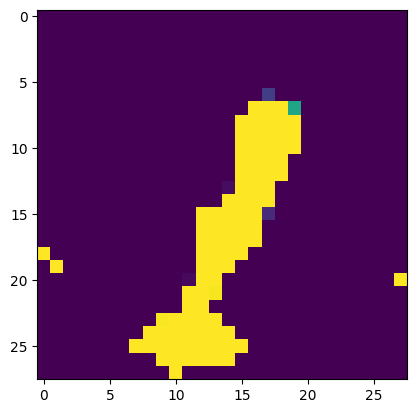

loss at end of epoch 206: 19451.2578125
test loss at end of epoch 206: 17679.75390625
RECONSTRUCTED


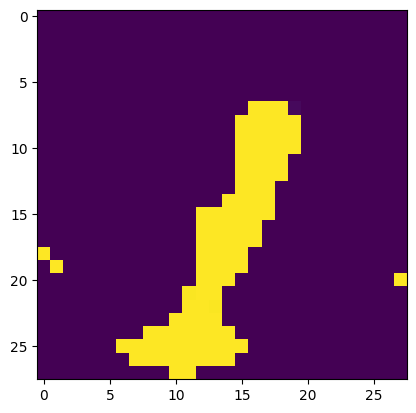

loss at end of epoch 207: 18839.99609375
test loss at end of epoch 207: 18763.375
RECONSTRUCTED


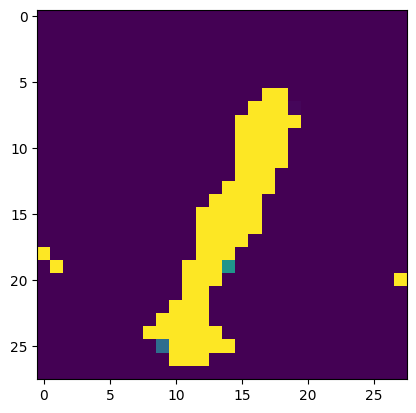

loss at end of epoch 208: 19988.98046875
test loss at end of epoch 208: 18627.171875
RECONSTRUCTED


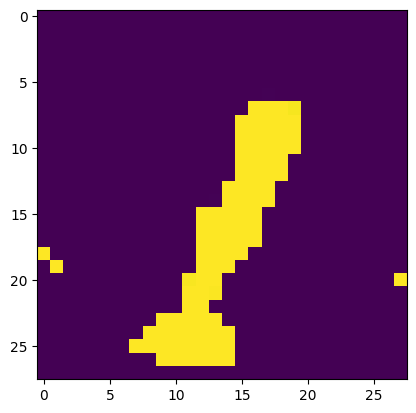

loss at end of epoch 209: 18553.36328125
test loss at end of epoch 209: 19312.013671875
RECONSTRUCTED


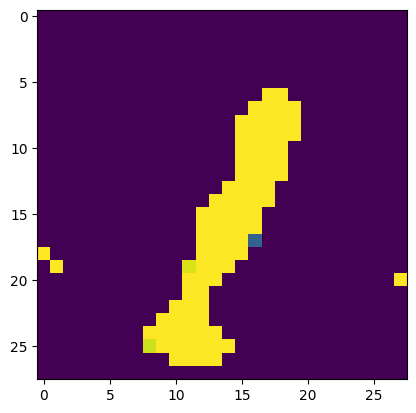

loss at end of epoch 210: 18293.02734375
test loss at end of epoch 210: 18500.740234375
RECONSTRUCTED


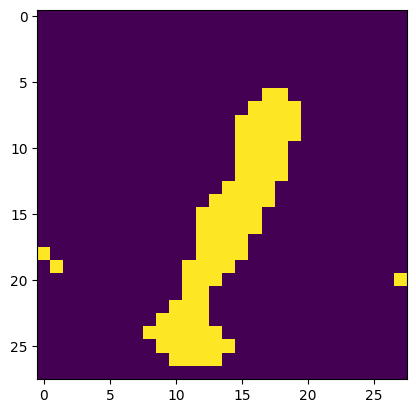

loss at end of epoch 211: 18730.630859375
test loss at end of epoch 211: 18301.609375
RECONSTRUCTED


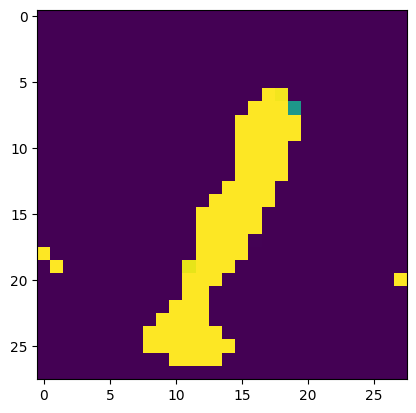

loss at end of epoch 212: 18121.798828125
test loss at end of epoch 212: 19079.826171875
RECONSTRUCTED


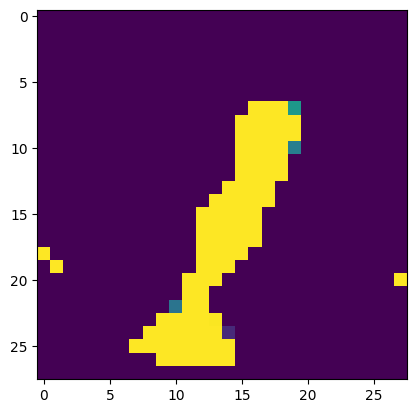

loss at end of epoch 213: 18505.18359375
test loss at end of epoch 213: 17869.408203125
RECONSTRUCTED


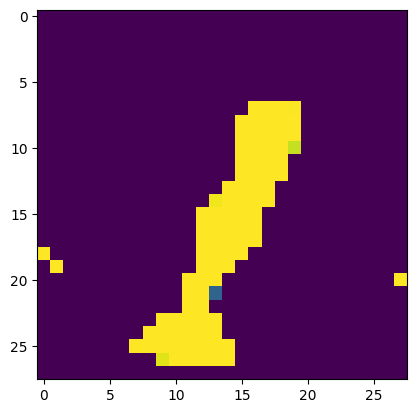

loss at end of epoch 214: 18748.146484375
test loss at end of epoch 214: 18695.484375
RECONSTRUCTED


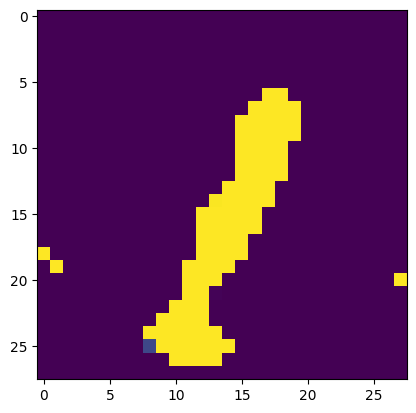

loss at end of epoch 215: 19303.232421875
test loss at end of epoch 215: 18655.009765625
RECONSTRUCTED


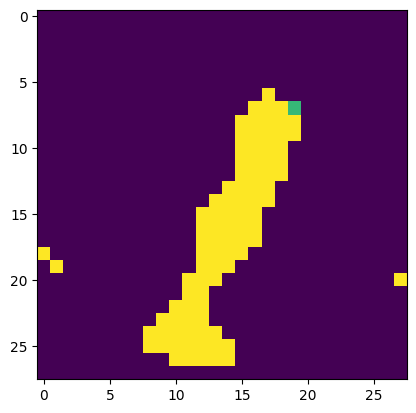

loss at end of epoch 216: 18565.201171875
test loss at end of epoch 216: 18886.71484375
RECONSTRUCTED


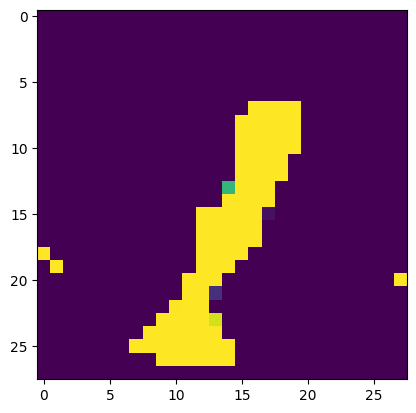

loss at end of epoch 217: 18552.64453125
test loss at end of epoch 217: 19609.76171875
RECONSTRUCTED


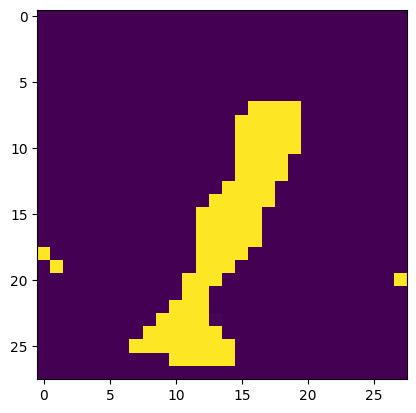

loss at end of epoch 218: 18265.1640625
test loss at end of epoch 218: 18194.705078125
RECONSTRUCTED


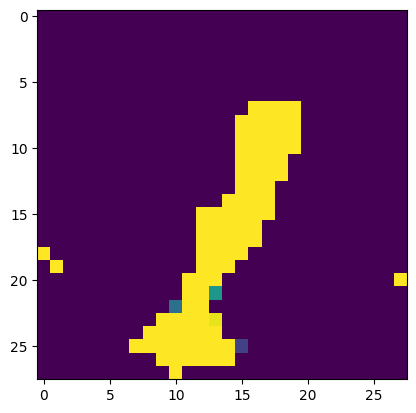

loss at end of epoch 219: 18543.287109375
test loss at end of epoch 219: 18260.380859375
RECONSTRUCTED


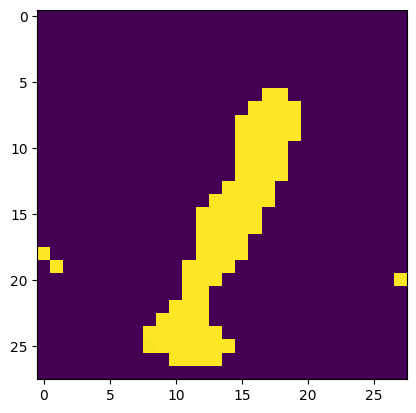

loss at end of epoch 220: 18709.98046875
test loss at end of epoch 220: 19033.029296875
RECONSTRUCTED


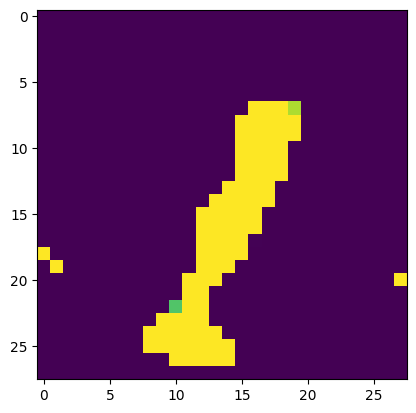

loss at end of epoch 221: 18783.05859375
test loss at end of epoch 221: 18539.3984375
RECONSTRUCTED


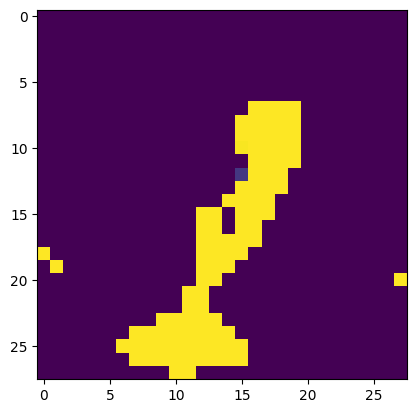

loss at end of epoch 222: 19170.6171875
test loss at end of epoch 222: 18927.818359375
RECONSTRUCTED


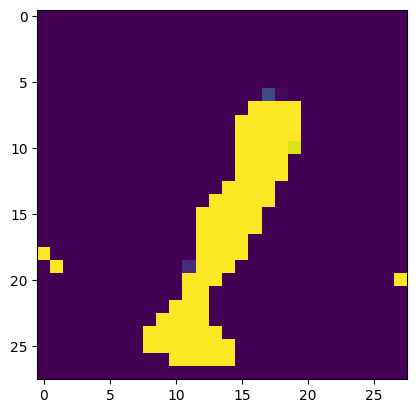

loss at end of epoch 223: 18795.79296875
test loss at end of epoch 223: 18801.099609375
RECONSTRUCTED


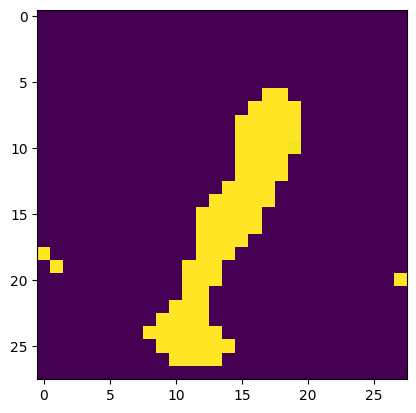

loss at end of epoch 224: 17671.71484375
test loss at end of epoch 224: 17250.40625
RECONSTRUCTED


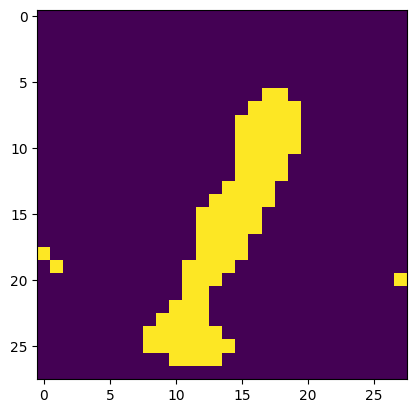

loss at end of epoch 225: 18838.16796875
test loss at end of epoch 225: 19045.2421875
RECONSTRUCTED


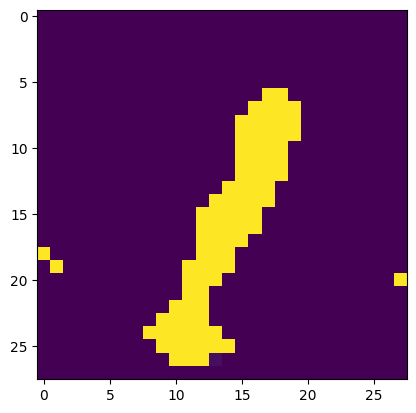

loss at end of epoch 226: 18253.76953125
test loss at end of epoch 226: 18274.17578125
RECONSTRUCTED


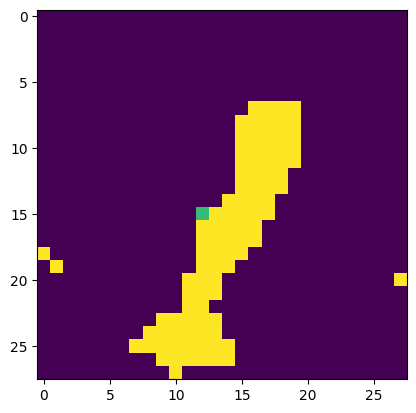

loss at end of epoch 227: 18667.66015625
test loss at end of epoch 227: 18405.5703125
RECONSTRUCTED


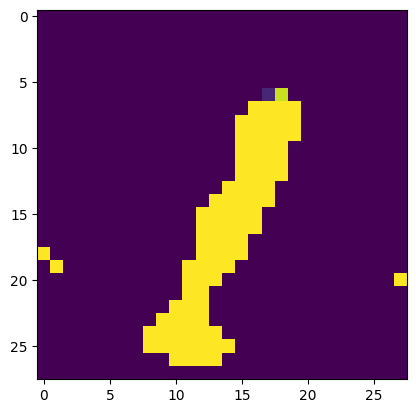

loss at end of epoch 228: 18604.27734375
test loss at end of epoch 228: 18693.029296875
RECONSTRUCTED


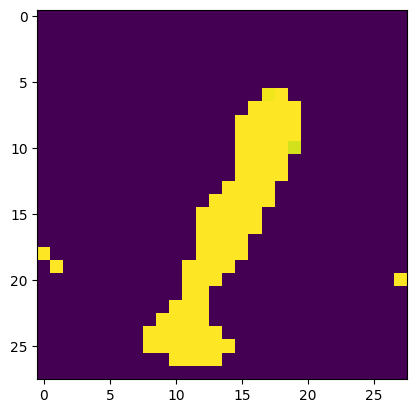

loss at end of epoch 229: 18228.390625
test loss at end of epoch 229: 17972.734375
RECONSTRUCTED


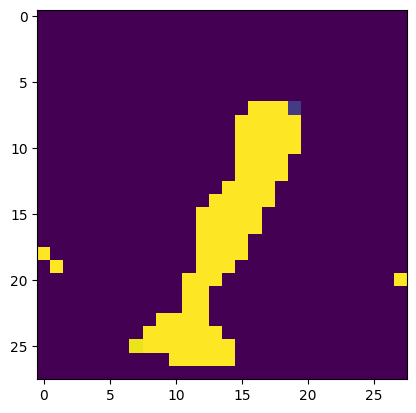

loss at end of epoch 230: 19242.95703125
test loss at end of epoch 230: 18516.994140625
RECONSTRUCTED


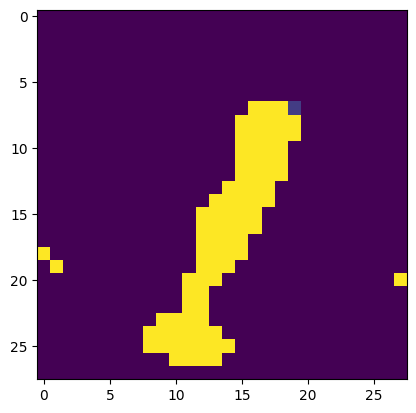

loss at end of epoch 231: 18418.3828125
test loss at end of epoch 231: 18848.041015625
RECONSTRUCTED


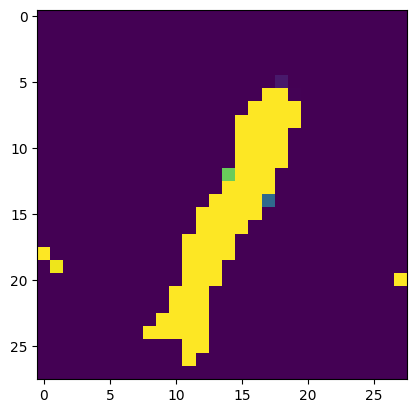

loss at end of epoch 232: 18158.33203125
test loss at end of epoch 232: 18684.09375
RECONSTRUCTED


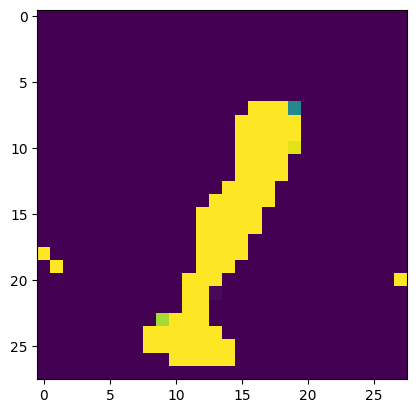

loss at end of epoch 233: 18362.30859375
test loss at end of epoch 233: 17649.75390625
RECONSTRUCTED


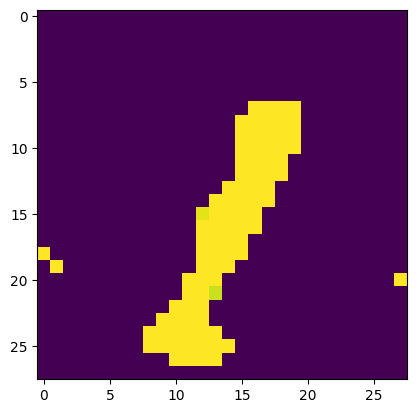

loss at end of epoch 234: 18466.35546875
test loss at end of epoch 234: 19025.1328125
RECONSTRUCTED


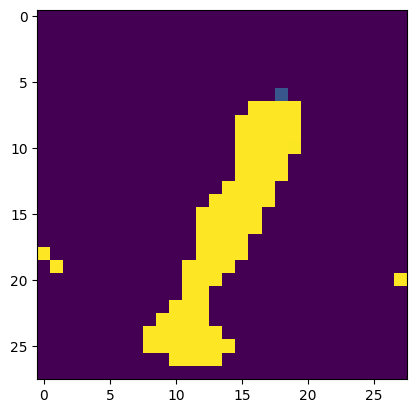

loss at end of epoch 235: 19114.900390625
test loss at end of epoch 235: 18484.05859375
RECONSTRUCTED


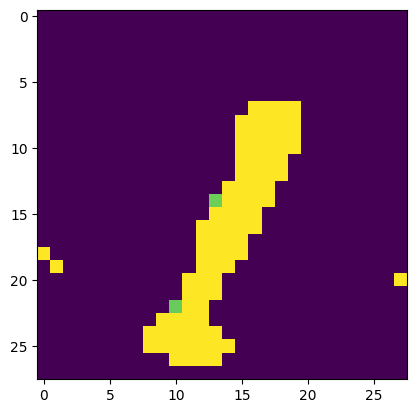

loss at end of epoch 236: 18688.716796875
test loss at end of epoch 236: 18782.36328125
RECONSTRUCTED


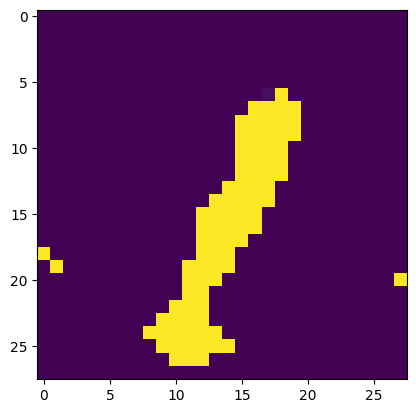

loss at end of epoch 237: 18209.3203125
test loss at end of epoch 237: 17707.29296875
RECONSTRUCTED


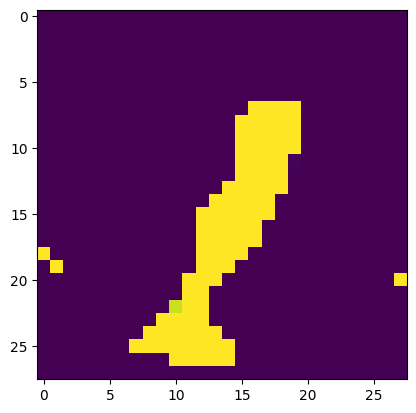

loss at end of epoch 238: 18454.337890625
test loss at end of epoch 238: 18294.046875
RECONSTRUCTED


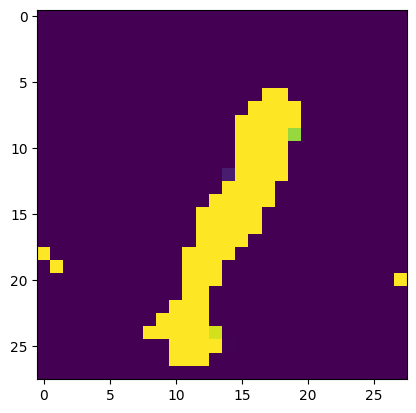

loss at end of epoch 239: 18602.8359375
test loss at end of epoch 239: 18370.484375
RECONSTRUCTED


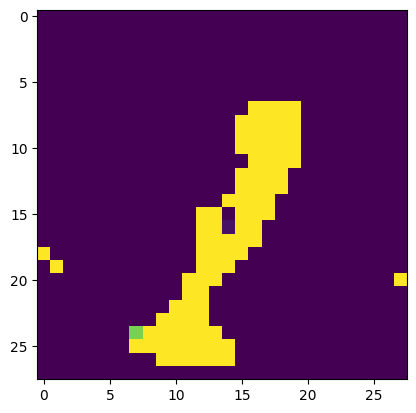

loss at end of epoch 240: 19197.1328125
test loss at end of epoch 240: 18434.5078125
RECONSTRUCTED


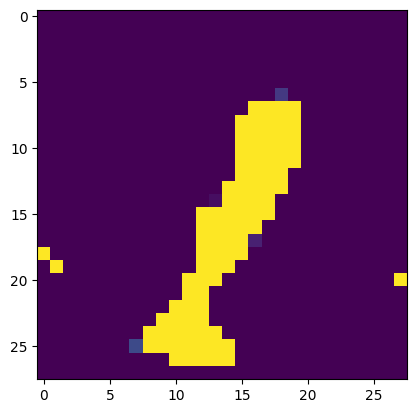

loss at end of epoch 241: 17866.01953125
test loss at end of epoch 241: 18562.25390625
RECONSTRUCTED


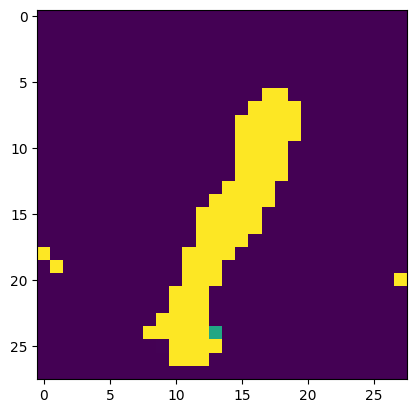

loss at end of epoch 242: 18551.57421875
test loss at end of epoch 242: 18599.212890625
RECONSTRUCTED


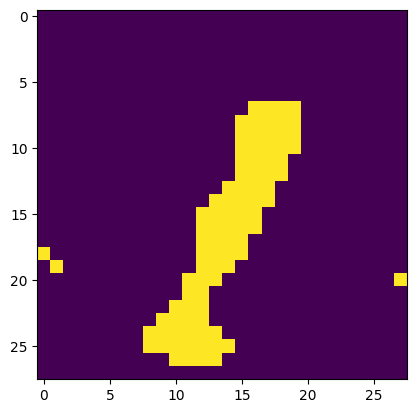

loss at end of epoch 243: 18364.091796875
test loss at end of epoch 243: 18864.087890625
RECONSTRUCTED


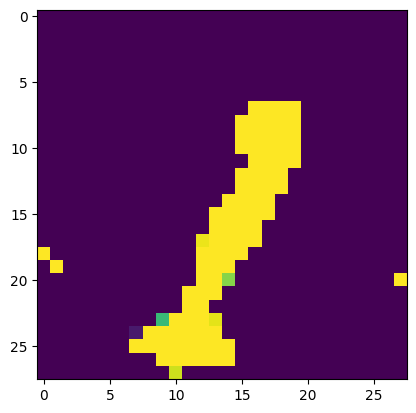

loss at end of epoch 244: 18841.94921875
test loss at end of epoch 244: 18619.8203125
RECONSTRUCTED


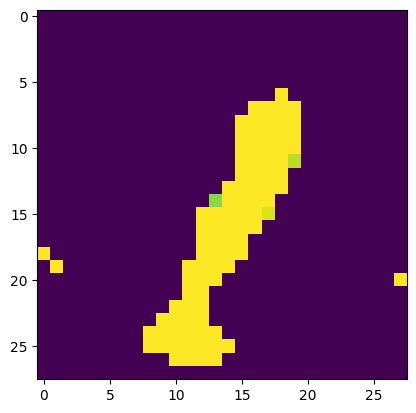

loss at end of epoch 245: 17935.54296875
test loss at end of epoch 245: 18974.416015625
RECONSTRUCTED


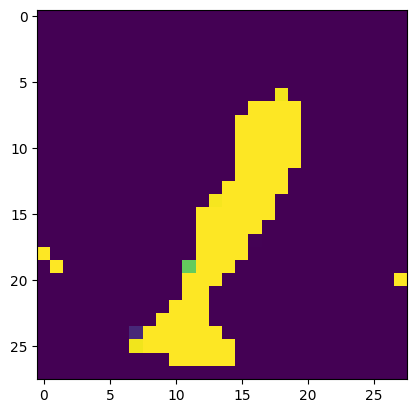

loss at end of epoch 246: 18739.0546875
test loss at end of epoch 246: 17771.931640625
RECONSTRUCTED


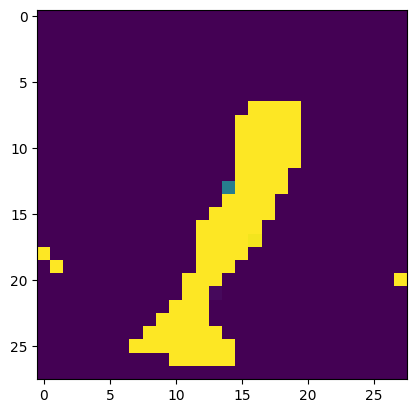

loss at end of epoch 247: 18677.765625
test loss at end of epoch 247: 18929.123046875
RECONSTRUCTED


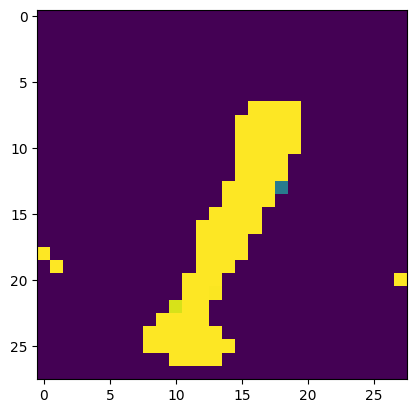

loss at end of epoch 248: 19350.10546875
test loss at end of epoch 248: 17336.720703125
RECONSTRUCTED


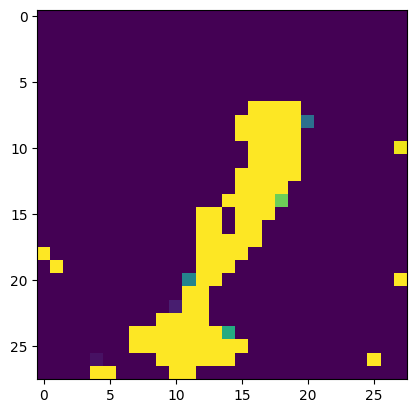

loss at end of epoch 249: 18345.69921875
test loss at end of epoch 249: 18790.62109375
RECONSTRUCTED


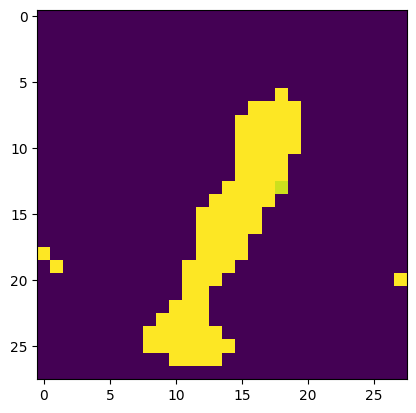

loss at end of epoch 250: 18641.99609375
test loss at end of epoch 250: 18562.048828125
RECONSTRUCTED


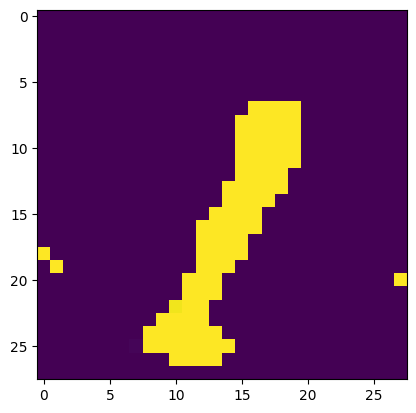

alpha: tensor([0.3548, 0.7262, 1.2572, 1.1683, 0.3548, 1.9201, 0.7262, 0.7262, 1.0975,
        0.9432, 0.3548, 0.3548, 0.3548, 0.8599, 0.3548, 0.7262, 0.3548, 0.6931,
        1.4687, 0.3548, 0.7262, 0.8008, 0.3548, 1.0976, 0.3548, 1.3925, 0.3548,
        1.0976, 0.3548, 0.3548, 0.6939, 0.3551, 0.7428, 0.3548, 0.7593, 0.7419,
        0.3548, 0.7261, 1.4689, 1.0976, 0.3548, 0.7262, 0.3548, 1.0976, 1.6377,
        0.3548, 1.0976, 0.7262, 0.7262, 0.7262], device='cuda:0')
loss at end of epoch 251: 19522.4453125
test loss at end of epoch 251: 17963.38671875
RECONSTRUCTED


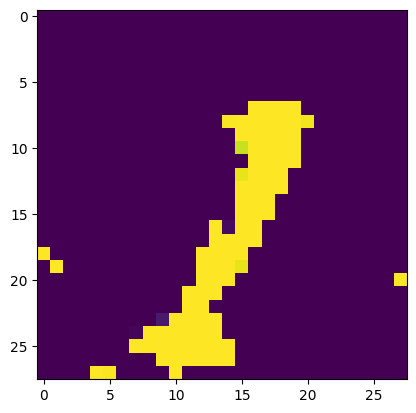

loss at end of epoch 252: 18160.982421875
test loss at end of epoch 252: 19157.400390625
RECONSTRUCTED


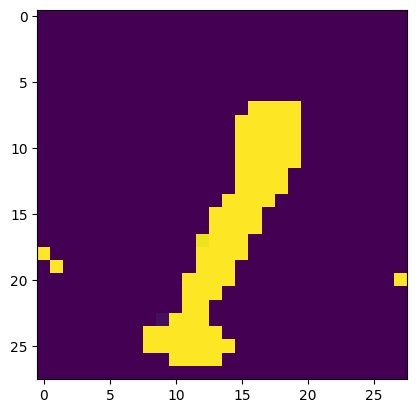

loss at end of epoch 253: 18115.90625
test loss at end of epoch 253: 17957.138671875
RECONSTRUCTED


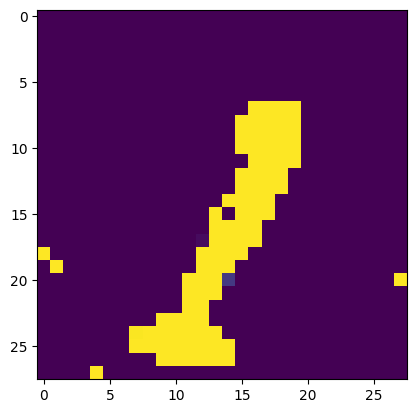

loss at end of epoch 254: 18726.984375
test loss at end of epoch 254: 18371.859375
RECONSTRUCTED


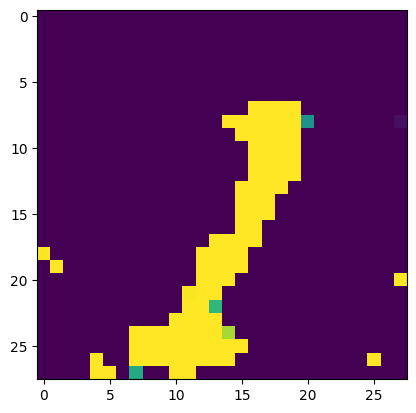

loss at end of epoch 255: 17874.474609375
test loss at end of epoch 255: 18183.14453125
RECONSTRUCTED


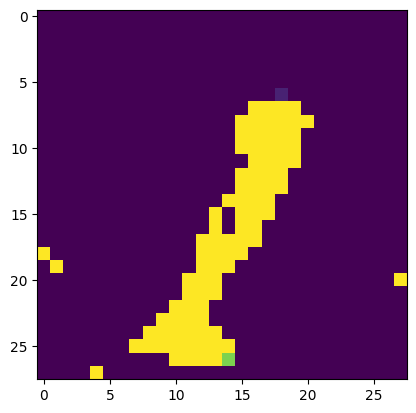

loss at end of epoch 256: 18296.486328125
test loss at end of epoch 256: 17911.505859375
RECONSTRUCTED


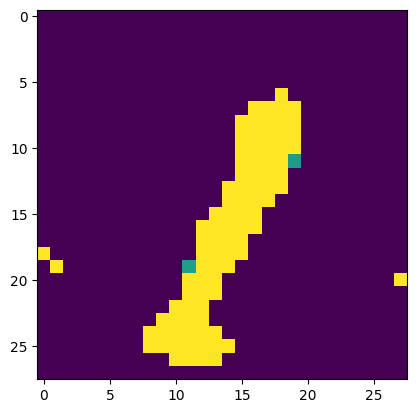

loss at end of epoch 257: 18464.6953125
test loss at end of epoch 257: 18821.328125
RECONSTRUCTED


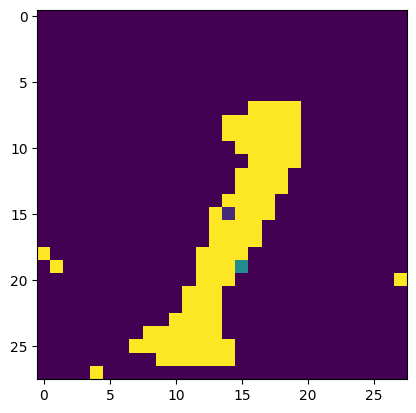

loss at end of epoch 258: 18960.453125
test loss at end of epoch 258: 17793.111328125
RECONSTRUCTED


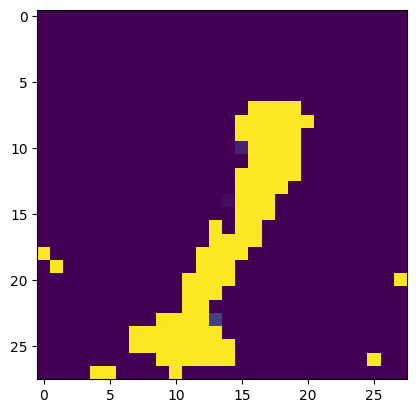

loss at end of epoch 259: 18494.951171875
test loss at end of epoch 259: 18014.9140625
RECONSTRUCTED


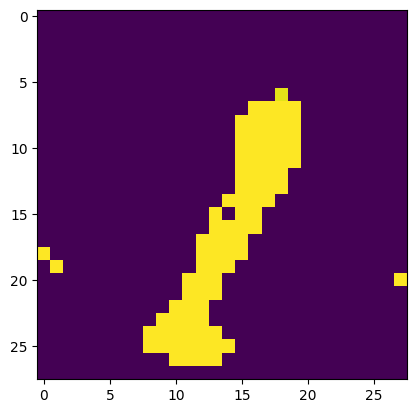

loss at end of epoch 260: 18965.17578125
test loss at end of epoch 260: 18091.3984375
RECONSTRUCTED


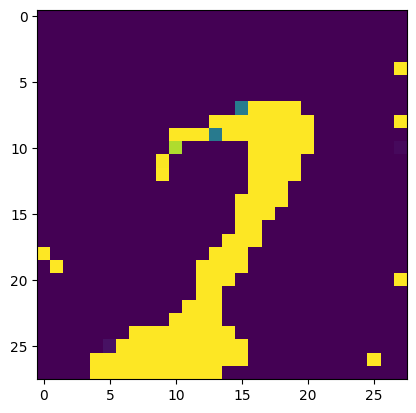

loss at end of epoch 261: 19203.455078125
test loss at end of epoch 261: 19176.744140625
RECONSTRUCTED


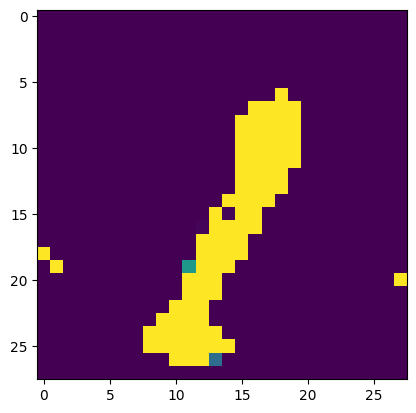

loss at end of epoch 262: 18837.46875
test loss at end of epoch 262: 19069.982421875
RECONSTRUCTED


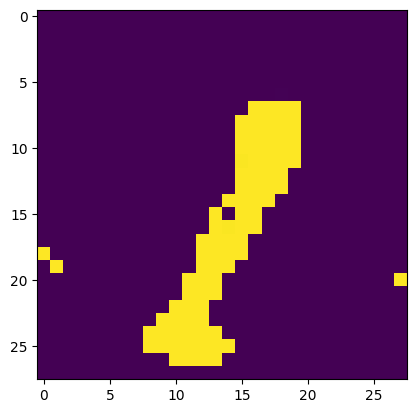

loss at end of epoch 263: 18176.052734375
test loss at end of epoch 263: 19370.44140625
RECONSTRUCTED


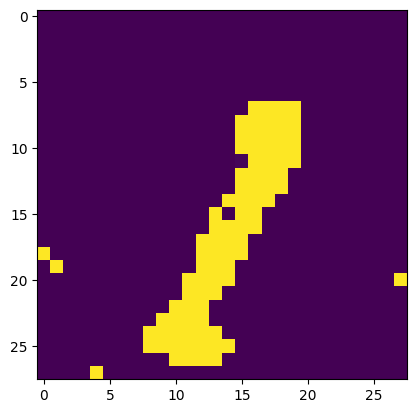

loss at end of epoch 264: 19669.130859375
test loss at end of epoch 264: 18034.630859375
RECONSTRUCTED


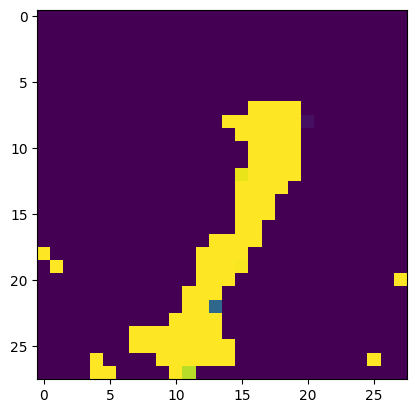

loss at end of epoch 265: 18716.3359375
test loss at end of epoch 265: 18025.634765625
RECONSTRUCTED


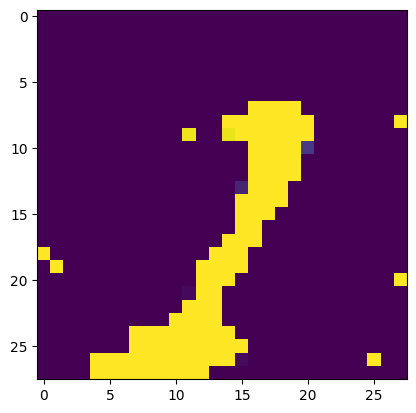

loss at end of epoch 266: 18267.162109375
test loss at end of epoch 266: 18604.09375
RECONSTRUCTED


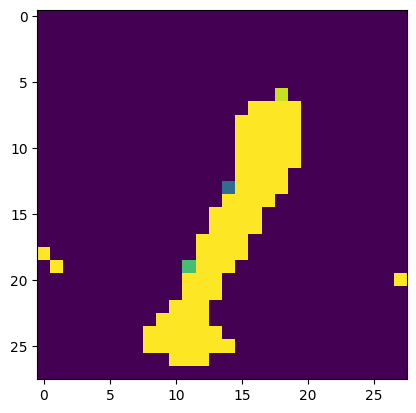

loss at end of epoch 267: 18745.2578125
test loss at end of epoch 267: 18594.45703125
RECONSTRUCTED


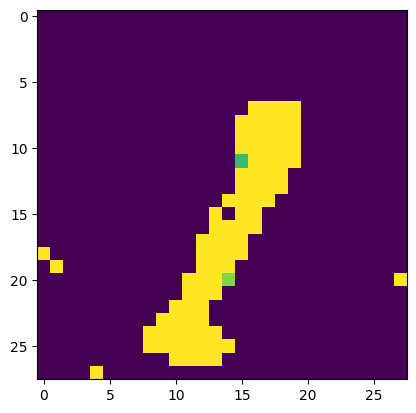

loss at end of epoch 268: 18621.1640625
test loss at end of epoch 268: 18658.134765625
RECONSTRUCTED


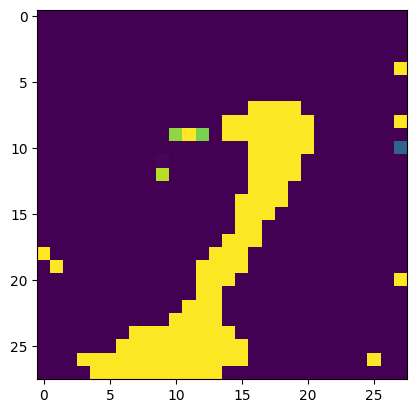

loss at end of epoch 269: 18162.912109375
test loss at end of epoch 269: 18891.1015625
RECONSTRUCTED


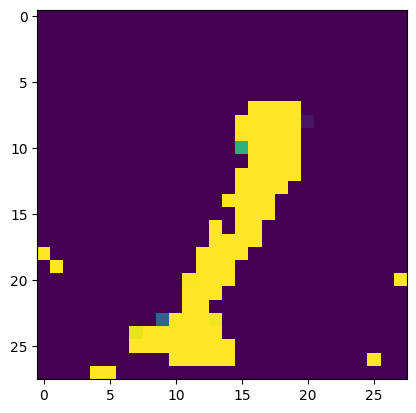

loss at end of epoch 270: 18136.607421875
test loss at end of epoch 270: 18500.55078125
RECONSTRUCTED


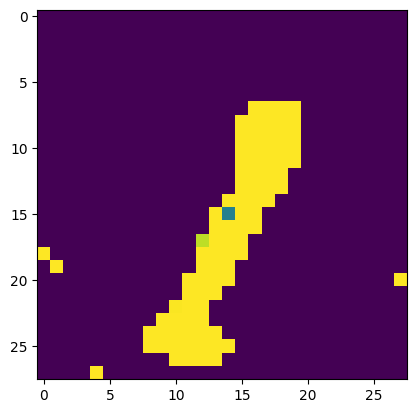

loss at end of epoch 271: 18427.1015625
test loss at end of epoch 271: 18589.98828125
RECONSTRUCTED


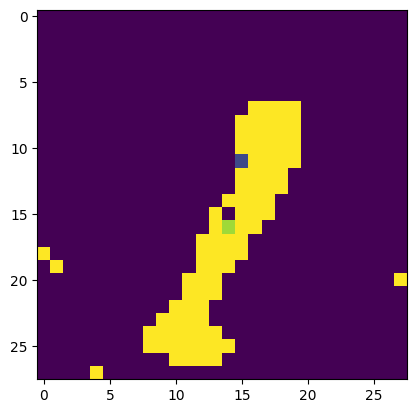

loss at end of epoch 272: 18542.197265625
test loss at end of epoch 272: 19044.2109375
RECONSTRUCTED


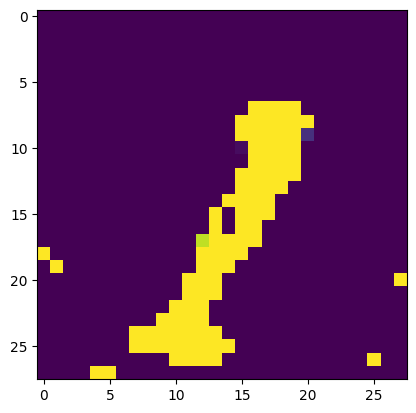

loss at end of epoch 273: 19122.2265625
test loss at end of epoch 273: 18446.05078125
RECONSTRUCTED


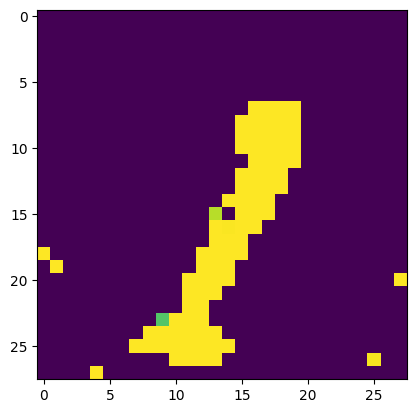

loss at end of epoch 274: 18067.88671875
test loss at end of epoch 274: 18578.578125
RECONSTRUCTED


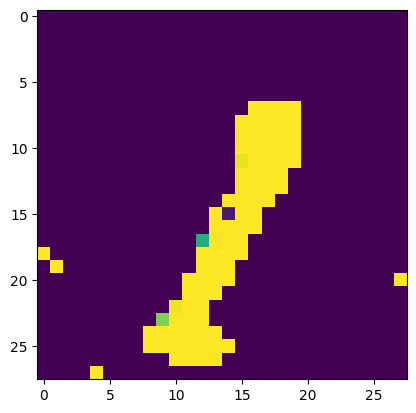

loss at end of epoch 275: 19823.4609375
test loss at end of epoch 275: 18414.81640625
RECONSTRUCTED


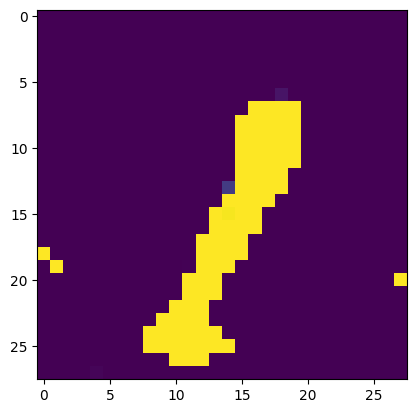

loss at end of epoch 276: 18610.5078125
test loss at end of epoch 276: 19001.748046875
RECONSTRUCTED


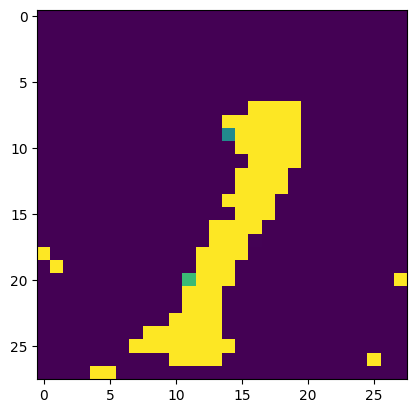

loss at end of epoch 277: 17712.845703125
test loss at end of epoch 277: 18165.94921875
RECONSTRUCTED


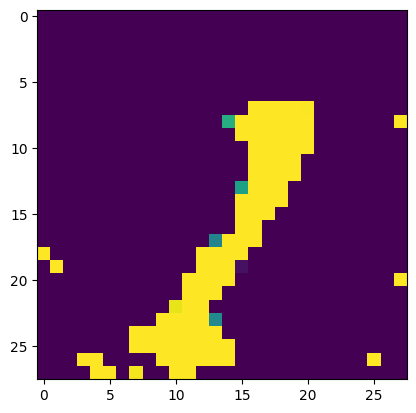

loss at end of epoch 278: 18266.189453125
test loss at end of epoch 278: 19252.111328125
RECONSTRUCTED


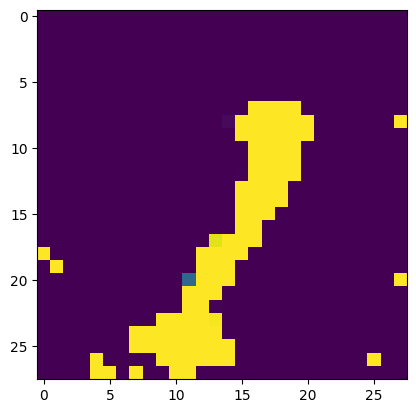

loss at end of epoch 279: 18859.115234375
test loss at end of epoch 279: 18851.9296875
RECONSTRUCTED


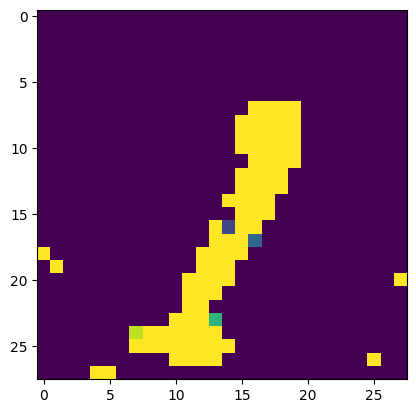

loss at end of epoch 280: 19058.5546875
test loss at end of epoch 280: 16967.826171875
RECONSTRUCTED


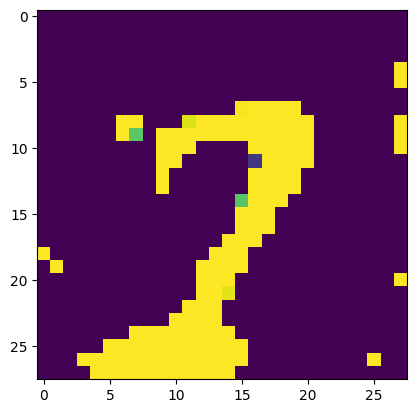

loss at end of epoch 281: 17994.033203125
test loss at end of epoch 281: 18492.48046875
RECONSTRUCTED


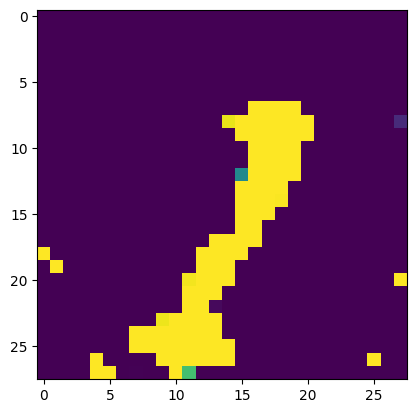

loss at end of epoch 282: 18605.5546875
test loss at end of epoch 282: 18779.6640625
RECONSTRUCTED


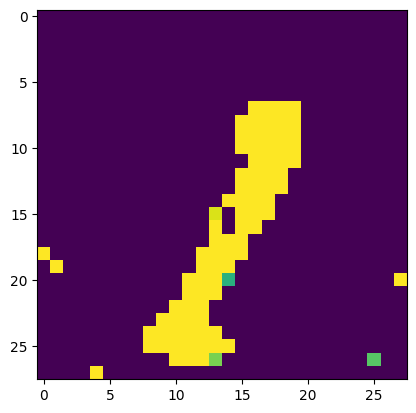

loss at end of epoch 283: 17855.392578125
test loss at end of epoch 283: 19359.181640625
RECONSTRUCTED


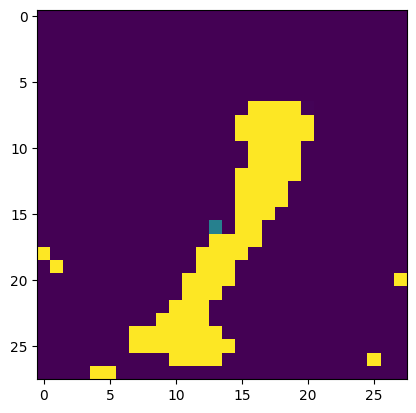

loss at end of epoch 284: 18827.662109375
test loss at end of epoch 284: 17926.78515625
RECONSTRUCTED


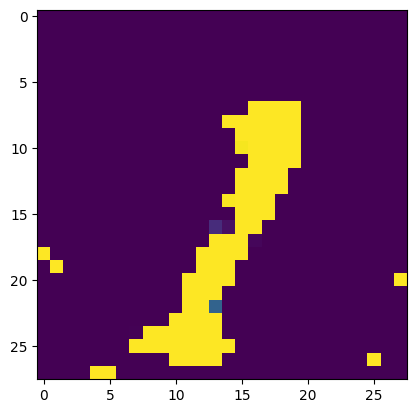

loss at end of epoch 285: 18197.66796875
test loss at end of epoch 285: 18468.84765625
RECONSTRUCTED


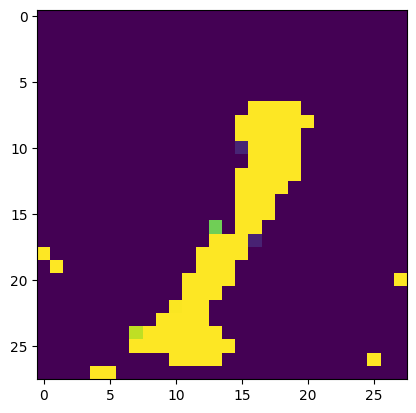

loss at end of epoch 286: 18904.900390625
test loss at end of epoch 286: 19351.337890625
RECONSTRUCTED


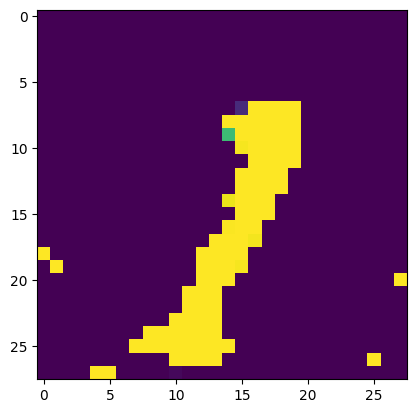

loss at end of epoch 287: 18737.302734375
test loss at end of epoch 287: 18768.16015625
RECONSTRUCTED


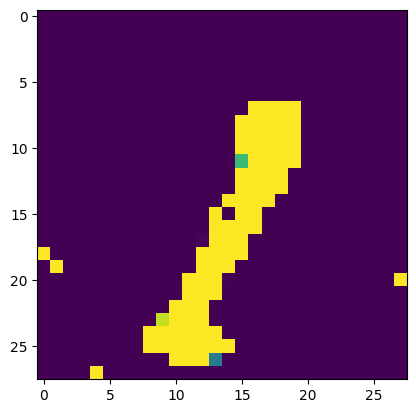

loss at end of epoch 288: 18600.279296875
test loss at end of epoch 288: 18306.03515625
RECONSTRUCTED


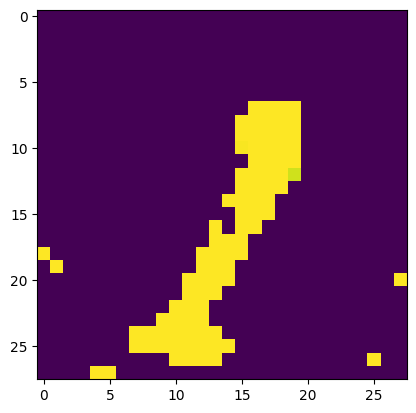

loss at end of epoch 289: 18534.513671875
test loss at end of epoch 289: 19035.4921875
RECONSTRUCTED


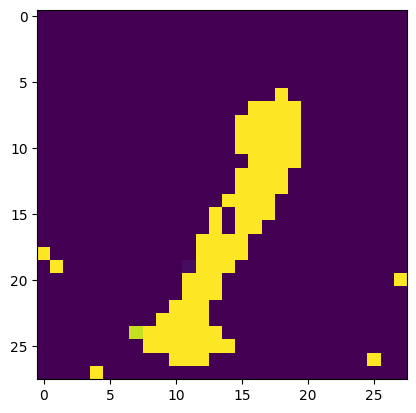

loss at end of epoch 290: 17808.978515625
test loss at end of epoch 290: 18199.119140625
RECONSTRUCTED


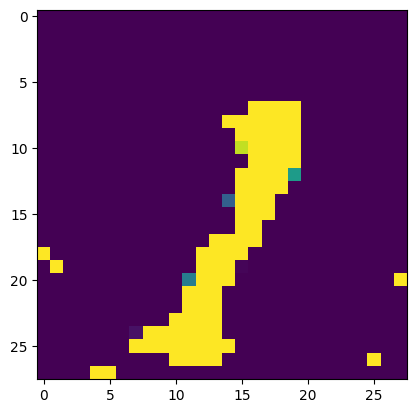

loss at end of epoch 291: 17953.904296875
test loss at end of epoch 291: 18137.37109375
RECONSTRUCTED


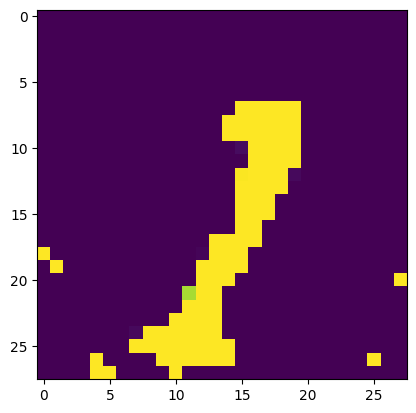

loss at end of epoch 292: 18105.73046875
test loss at end of epoch 292: 18330.310546875
RECONSTRUCTED


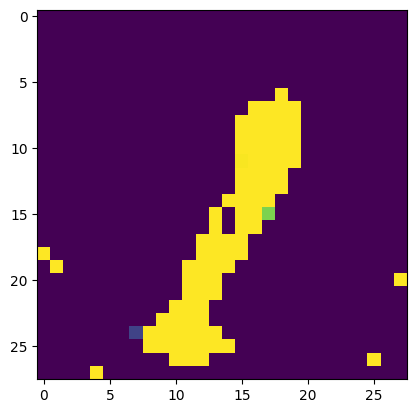

loss at end of epoch 293: 18646.01171875
test loss at end of epoch 293: 18519.349609375
RECONSTRUCTED


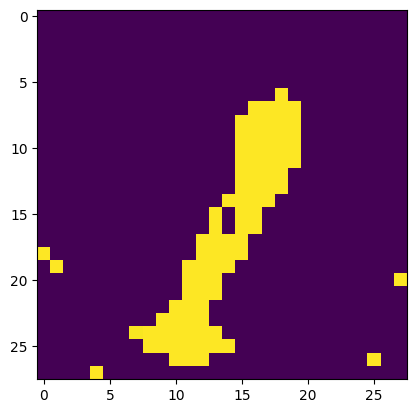

loss at end of epoch 294: 18522.5703125
test loss at end of epoch 294: 17800.3359375
RECONSTRUCTED


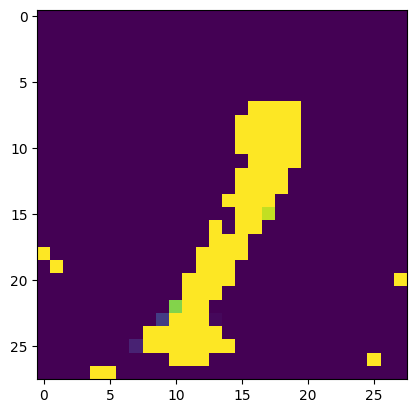

loss at end of epoch 295: 18996.9375
test loss at end of epoch 295: 19107.087890625
RECONSTRUCTED


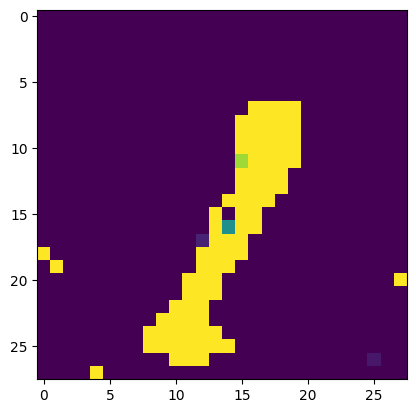

loss at end of epoch 296: 17722.3984375
test loss at end of epoch 296: 18343.32421875
RECONSTRUCTED


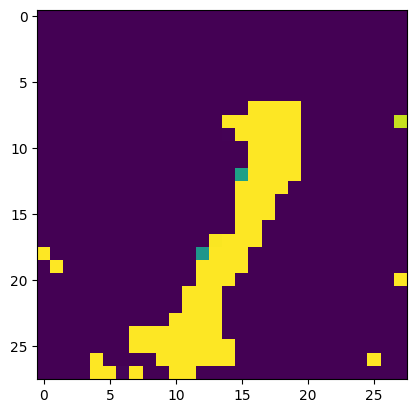

loss at end of epoch 297: 19184.53515625
test loss at end of epoch 297: 17950.556640625
RECONSTRUCTED


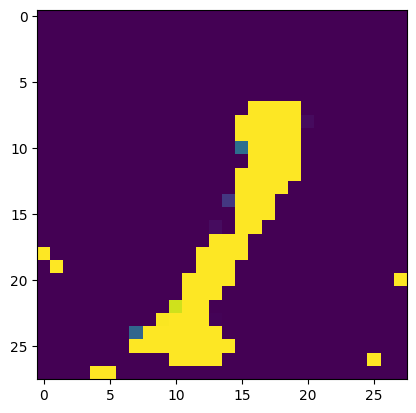

loss at end of epoch 298: 18389.31640625
test loss at end of epoch 298: 18714.240234375
RECONSTRUCTED


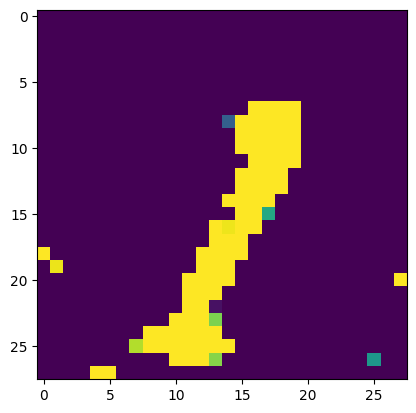

loss at end of epoch 299: 18567.3828125
test loss at end of epoch 299: 18044.89453125
RECONSTRUCTED


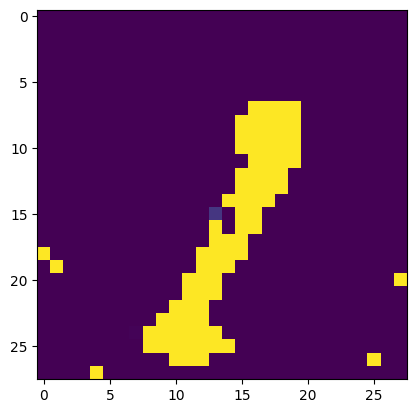

In [57]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
                                           batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
                                          batch_size=100, shuffle=True)
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")

latent_dim = 50

model = DirVAE(latent_dim).to(device)

params = model.parameters()
optimizer = optim.Adam(params, lr=5e-4)

alpha =  ((1 - 1/latent_dim) * torch.ones(size=(latent_dim,))).to(device)

epochs = 300

scaler = GradScaler()

for epoch in range(epochs):
    model.train()
    for batch_idx, (x, _) in enumerate(train_loader): 
        x = x.to(device)
        optimizer.zero_grad()
        with autocast():
            x_hat, alpha_hat, z = model(x)
            loss = ELBO(x_hat, x, alpha_hat, alpha)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        scaler.step(optimizer)
        scaler.update()
    print(f'loss at end of epoch {epoch}: {loss.item()}')
    
    model.eval()
    with torch.no_grad():
        for i, (val_x, _) in enumerate(test_loader):
            val_x = val_x.to(device)
            val_x_hat, val_alpha_hat, val_z = model(val_x)
            test_loss = ELBO(val_x_hat, val_x, val_alpha_hat, alpha)
    print(f'test loss at end of epoch {epoch}: {test_loss.item()}')
    
    if epoch == 0:
        print('ORIGINAL')
        plt.imshow(test_loader.dataset[0][0].numpy().reshape(28,28))
        plt.show()
    with torch.no_grad():
        sample = test_loader.dataset[0][0].to(device)
        img, img_alpha_hat, img_z = model(sample)
    img = torch.sigmoid(img)
    img = img.to('cpu').numpy().reshape(28,28)
    print('RECONSTRUCTED')
    plt.imshow(img)
    plt.show()
    
    if epoch % 50 == 0 and epoch != 0:
        alpha = update_alpha_mme(z)
        print('alpha:', alpha)